##Download the Dataset

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

In [ ]:
import os
import requests

# Base URL for downloading
base_url = "https://github.com/Zdong104/FNSPID_Financial_News_Dataset/raw/main/dataset_test/CNN-for-Time-Series-Prediction/data/"

# List of all CSV filenames
files = [
    "AAPL.csv", "ABBV.csv", "AMD.csv", "AMZN.csv", "BABA.csv", "BRK-B.csv", "C.csv",
    "COST.csv", "CVX.csv", "DIS.csv", "GE.csv", "GOOG.csv", "INTC.csv", "KO.csv",
    "MSFT.csv", "QQQ.csv", "SBUX.csv", "T.csv", "TSLA.csv", "TSM.csv", "WFC.csv",
    "WMT.csv", "aal.csv", "amgn.csv", "bhp.csv", "bidu.csv", "biib.csv", "cat.csv",
    "cmcsa.csv", "cmg.csv", "cop.csv", "crm.csv", "dal.csv", "ebay.csv", "gild.csv",
    "gld.csv", "gsk.csv", "mrk.csv", "mu.csv", "nke.csv", "nvda.csv", "orcl.csv",
    "pep.csv", "pypl.csv", "qcom.csv", "tgt.csv", "tm.csv", "uso.csv", "v.csv", "xlf.csv"
]

# Create a directory to store the downloaded files
os.makedirs("data", exist_ok=True)

# Download each file
for file in files:
    url = base_url + file
    response = requests.get(url)
    if response.status_code == 200:
        with open(os.path.join("data", file), 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {file}")
    else:
        print(f"Failed to download {file} (Status code: {response.status_code})")


Downloaded AAPL.csv
Downloaded ABBV.csv
Downloaded AMD.csv
Downloaded AMZN.csv
Downloaded BABA.csv
Downloaded BRK-B.csv
Downloaded C.csv
Downloaded COST.csv
Downloaded CVX.csv
Downloaded DIS.csv
Downloaded GE.csv
Downloaded GOOG.csv
Downloaded INTC.csv
Downloaded KO.csv
Downloaded MSFT.csv
Downloaded QQQ.csv
Downloaded SBUX.csv
Downloaded T.csv
Downloaded TSLA.csv
Downloaded TSM.csv
Downloaded WFC.csv
Downloaded WMT.csv
Downloaded aal.csv
Downloaded amgn.csv
Downloaded bhp.csv
Downloaded bidu.csv
Downloaded biib.csv
Downloaded cat.csv
Downloaded cmcsa.csv
Downloaded cmg.csv
Downloaded cop.csv
Downloaded crm.csv
Downloaded dal.csv
Downloaded ebay.csv
Downloaded gild.csv
Downloaded gld.csv
Downloaded gsk.csv
Downloaded mrk.csv
Downloaded mu.csv
Downloaded nke.csv
Downloaded nvda.csv
Downloaded orcl.csv
Downloaded pep.csv
Downloaded pypl.csv
Downloaded qcom.csv
Downloaded tgt.csv
Downloaded tm.csv
Downloaded uso.csv
Downloaded v.csv
Downloaded xlf.csv


In [ ]:
import os
import pandas as pd

# Folder containing the individual CSV files
folder_path = "data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Target columns to shift for tomorrow prediction
target_cols = ['Volume', 'Open', 'High', 'Low', 'Close', 'Adj close']
prepared_dfs = []

for file in csv_files:
    symbol = file.replace('.csv', '').upper()
    file_path = os.path.join(folder_path, file)

    # Read and sort
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # Shift target columns to represent "tomorrow's" values
    shifted = df[target_cols].shift(-1)
    shifted.columns = [col + '_tomorrow' for col in target_cols]

    # Merge today's data with tomorrow's targets
    df_prepared = pd.concat([df, shifted], axis=1)

    # Drop last row (no future data for it)
    df_prepared.dropna(inplace=True)

    # Add symbol column (overwrite if already exists just to be sure)
    df_prepared['Symbol'] = symbol

    prepared_dfs.append(df_prepared)

# Concatenate all processed files
final_df = pd.concat(prepared_dfs, ignore_index=True)

# Save to CSV
final_df.to_csv("prepared_all_stocks.csv", index=False)
print("Prepared dataset saved to 'prepared_all_stocks.csv'")


Prepared dataset saved to 'prepared_all_stocks.csv'


In [ ]:

concatenated_data = pd.read_csv("prepared_all_stocks.csv")

concatenated_data

,Date,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment,Volume_tomorrow,Open_tomorrow,High_tomorrow,Low_tomorrow,Close_tomorrow,Adj close_tomorrow,Symbol
0,2015-01-02 00:00:00+00:00,6886000.0,41.064999,41.490002,40.445000,40.720001,36.923927,3.000000,1.0,0.500025,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637,SBUX
1,2015-01-05 00:00:00+00:00,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637,3.000000,0.0,0.500025,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936,SBUX
2,2015-01-06 00:00:00+00:00,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936,3.000000,1.0,0.500025,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049,SBUX
3,2015-01-07 00:00:00+00:00,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049,3.666667,1.0,0.666692,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979,SBUX
4,2015-01-08 00:00:00+00:00,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979,4.000000,1.0,0.750025,27556800.0,40.494999,40.755001,39.560001,39.895000,36.175831,SBUX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127882,2023-12-08 00:00:00+00:00,2537000.0,62.240002,62.779999,62.060001,62.459999,62.459999,4.000000,1.0,0.750025,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000,BHP
127883,2023-12-11 00:00:00+00:00,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000,3.400000,1.0,0.600025,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002,BHP
127884,2023-12-12 00:00:00+00:00,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002,3.000000,1.0,0.500025,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003,BHP
127885,2023-12-13 00:00:00+00:00,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003,4.500000,1.0,0.875025,3058500.0,64.980003,65.860001,64.970001,65.529999,65.529999,BHP


In [ ]:
df=concatenated_data

df['News_flag'] = df['News_flag'].astype(int)

count_0 = (df['News_flag'] == 0).sum()
count_1 = (df['News_flag'] == 1).sum()

count_0

np.int64(41822)

In [ ]:
count_1

np.int64(86065)

In [ ]:
print(df.columns.tolist())


['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'Adj close', 'Sentiment_gpt', 'News_flag', 'Scaled_sentiment', 'Volume_tomorrow', 'Open_tomorrow', 'High_tomorrow', 'Low_tomorrow', 'Close_tomorrow', 'Adj close_tomorrow', 'Symbol']


In [ ]:

from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
# Prepare features (X) and targets (Y)
X = df.drop(columns=[
    'Date',              # not useful directly
    'Volume_tomorrow',
    'Open_tomorrow',
    'High_tomorrow',
    'Low_tomorrow',
    'Close_tomorrow',
    'Adj close_tomorrow'
])

Y = df[[
    'Volume_tomorrow',
    'Open_tomorrow',
    'High_tomorrow',
    'Low_tomorrow',
    'Close_tomorrow',
    'Adj close_tomorrow'
]]

In [ ]:
X

,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment,Symbol
0,6886000.0,41.064999,41.490002,40.445000,40.720001,36.923927,3.000000,1,0.500025,SBUX
1,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637,3.000000,0,0.500025,SBUX
2,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936,3.000000,1,0.500025,SBUX
3,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049,3.666667,1,0.666692,SBUX
4,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979,4.000000,1,0.750025,SBUX
...,...,...,...,...,...,...,...,...,...,...
127882,2537000.0,62.240002,62.779999,62.060001,62.459999,62.459999,4.000000,1,0.750025,BHP
127883,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000,3.400000,1,0.600025,BHP
127884,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002,3.000000,1,0.500025,BHP
127885,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003,4.500000,1,0.875025,BHP


In [ ]:
Y

,Volume_tomorrow,Open_tomorrow,High_tomorrow,Low_tomorrow,Close_tomorrow,Adj close_tomorrow
0,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637
1,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936
2,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049
3,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979
4,27556800.0,40.494999,40.755001,39.560001,39.895000,36.175831
...,...,...,...,...,...,...
127882,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000
127883,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002
127884,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003
127885,3058500.0,64.980003,65.860001,64.970001,65.529999,65.529999


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
le = LabelEncoder()

X['Symbol'] = le.fit_transform(X['Symbol'])

In [ ]:
X

,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment,Symbol
0,6886000.0,41.064999,41.490002,40.445000,40.720001,36.923927,3.000000,1,0.500025,39
1,11623800.0,40.070000,40.334999,39.744999,39.939999,36.216637,3.000000,0,0.500025,39
2,7664400.0,40.169998,40.195000,39.279999,39.615002,35.921936,3.000000,1,0.500025,39
3,9732600.0,39.875000,40.615002,39.700001,40.590000,36.806049,3.666667,1,0.666692,39
4,13170600.0,41.165001,41.650002,41.009998,41.244999,37.399979,4.000000,1,0.750025,39
...,...,...,...,...,...,...,...,...,...,...
127882,2537000.0,62.240002,62.779999,62.060001,62.459999,62.459999,4.000000,1,0.750025,7
127883,2896200.0,61.759998,62.189999,61.279999,62.070000,62.070000,3.400000,1,0.600025,7
127884,1639100.0,62.290001,62.330002,61.790001,62.150002,62.150002,3.000000,1,0.500025,7
127885,2656400.0,62.459999,64.080002,62.110001,64.050003,64.050003,4.500000,1,0.875025,7


##EDA

In [ ]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127887 entries, 0 to 127886
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                127887 non-null  object 
 1   Volume              127887 non-null  float64
 2   Open                127887 non-null  float64
 3   High                127887 non-null  float64
 4   Low                 127887 non-null  float64
 5   Close               127887 non-null  float64
 6   Adj close           127887 non-null  float64
 7   Sentiment_gpt       127887 non-null  float64
 8   News_flag           127887 non-null  int64  
 9   Scaled_sentiment    127887 non-null  float64
 10  Volume_tomorrow     127887 non-null  float64
 11  Open_tomorrow       127887 non-null  float64
 12  High_tomorrow       127887 non-null  float64
 13  Low_tomorrow        127887 non-null  float64
 14  Close_tomorrow      127887 non-null  float64
 15  Adj close_tomorrow  127887 non-nul

In [ ]:
missing = df.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])


Missing values per column:
 Series([], dtype: int64)


In [ ]:
print(df.columns.tolist())  # Show all column names
print(df.head())            # Preview first few rows


['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'Adj close', 'Sentiment_gpt', 'News_flag', 'Scaled_sentiment', 'Volume_tomorrow', 'Open_tomorrow', 'High_tomorrow', 'Low_tomorrow', 'Close_tomorrow', 'Adj close_tomorrow', 'Symbol']
                        Date      Volume       Open       High        Low  \
0  2015-01-02 00:00:00+00:00   6886000.0  41.064999  41.490002  40.445000   
1  2015-01-05 00:00:00+00:00  11623800.0  40.070000  40.334999  39.744999   
2  2015-01-06 00:00:00+00:00   7664400.0  40.169998  40.195000  39.279999   
3  2015-01-07 00:00:00+00:00   9732600.0  39.875000  40.615002  39.700001   
4  2015-01-08 00:00:00+00:00  13170600.0  41.165001  41.650002  41.009998   

       Close  Adj close  Sentiment_gpt  News_flag  Scaled_sentiment  \
0  40.720001  36.923927       3.000000          1          0.500025   
1  39.939999  36.216637       3.000000          0          0.500025   
2  39.615002  35.921936       3.000000          1          0.500025   
3  40.590000  36.806

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Symbol', 'Date'], inplace=True)

In [ ]:
print("Unique Symbols:", df['Symbol'].nunique())
print("Date Range:", df['Date'].min(), "to", df['Date'].max())

Unique Symbols: 50
Date Range: 2009-04-14 00:00:00+00:00 to 2023-12-27 00:00:00+00:00


In [ ]:
# Class imbalance in News_flag
print(df['News_flag'].value_counts(normalize=True))


News_flag
1    0.672977
0    0.327023
Name: proportion, dtype: float64


In [ ]:
# Ensure Symbol is treated as a category
df['Symbol'] = df['Symbol'].astype('category')

# Get numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [ ]:
import matplotlib.pyplot as plt

df = df.reset_index()

for symbol in df['Symbol'].unique():  # Iterate through unique symbols
    plt.figure(figsize=(10, 5))

    # Filter data for the current symbol
    symbol_df = df[df['Symbol'] == symbol]

    # Calculate rolling mean and std
    rolling_mean = symbol_df['Close'].rolling(window=30).mean()
    rolling_std = symbol_df['Close'].rolling(window=30).std()

    rolling_mean.plot(label='Rolling Mean')
    rolling_std.plot(label='Rolling Std')

    plt.title(f'{symbol} - 30-Day Rolling Mean and Std')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

News_flag
1    67.297692
0    32.702308
Name: proportion, dtype: float64


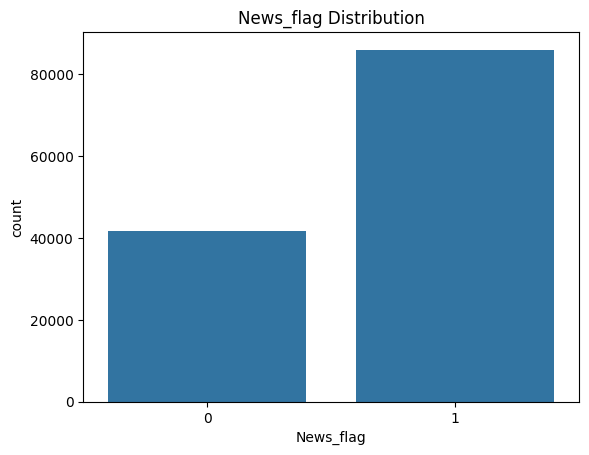

In [ ]:

df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# News_flag class imbalance
print(df['News_flag'].value_counts(normalize=True) * 100)
sns.countplot(x='News_flag', data=df)
plt.title("News_flag Distribution")
plt.show()


#### news impact in context

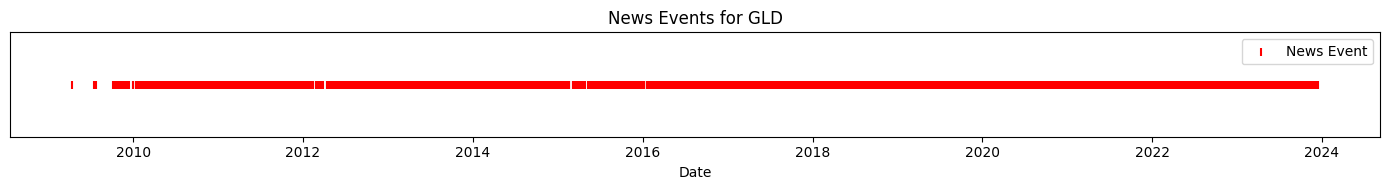

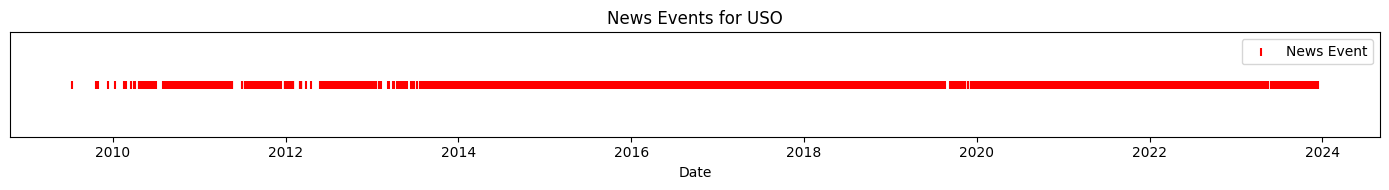

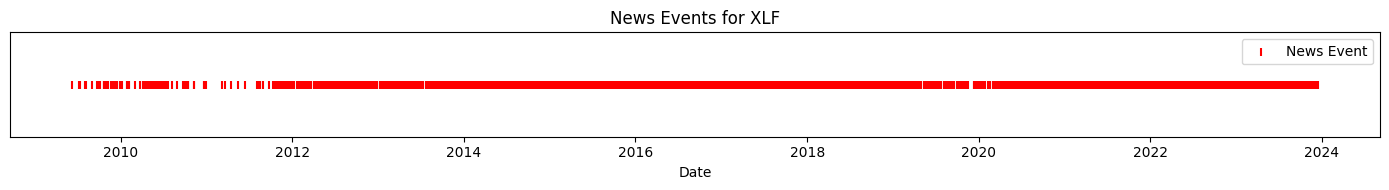

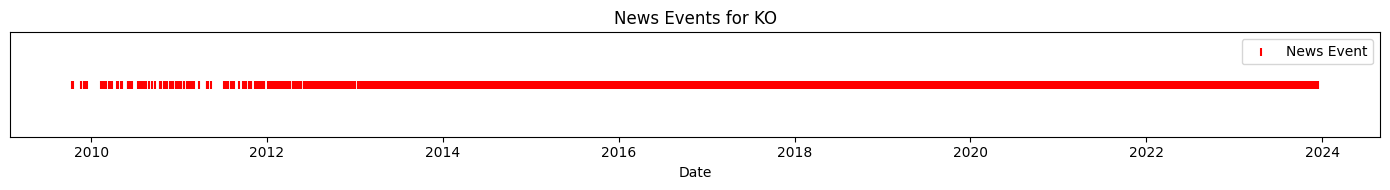

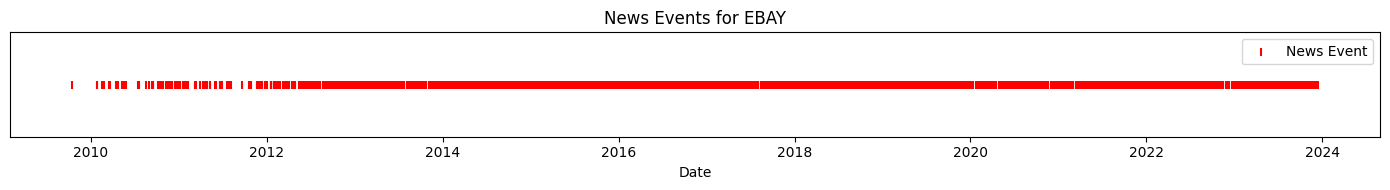

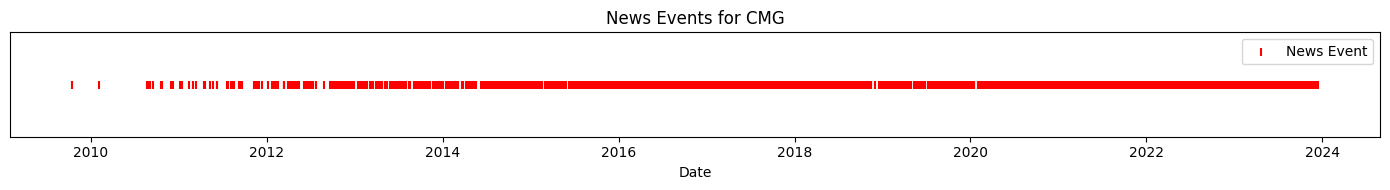

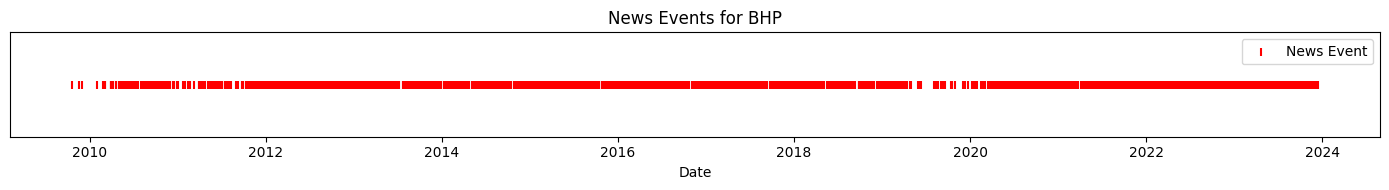

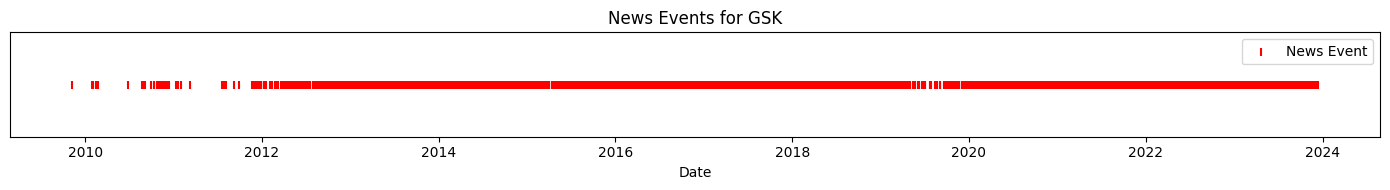

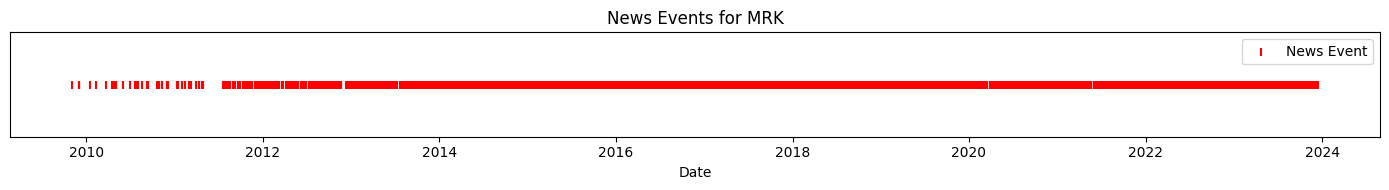

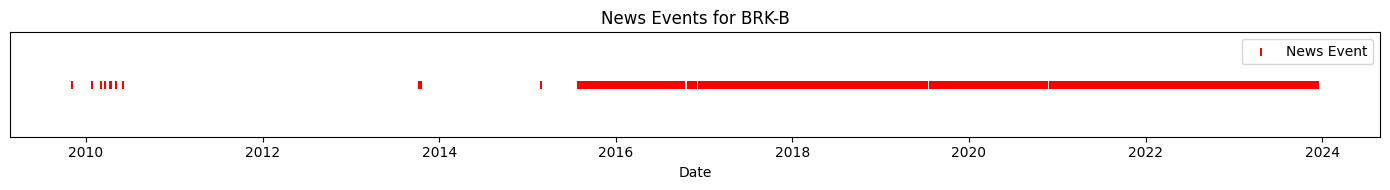

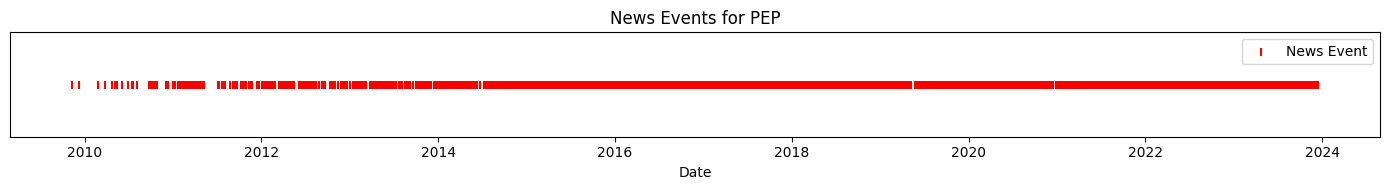

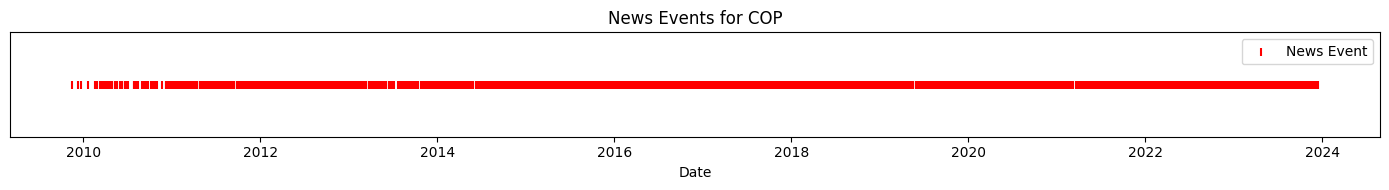

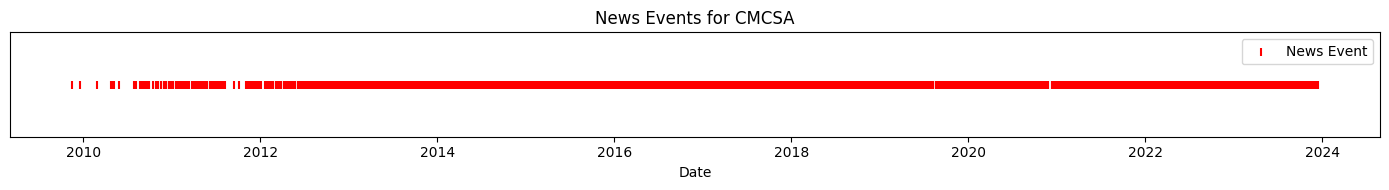

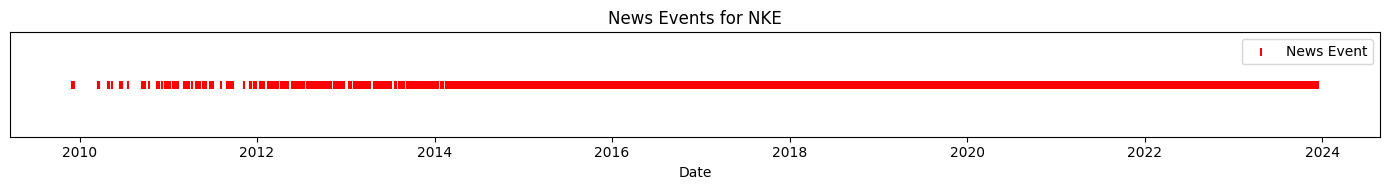

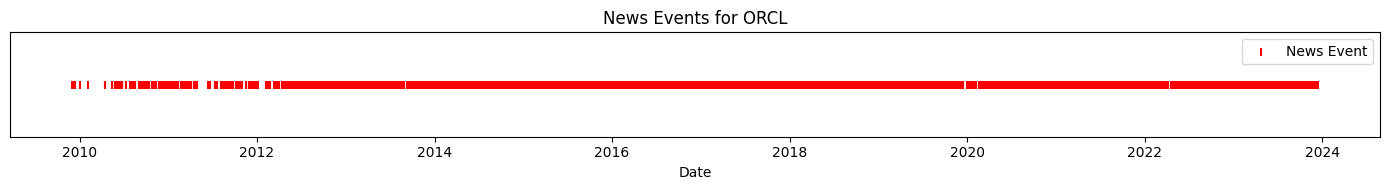

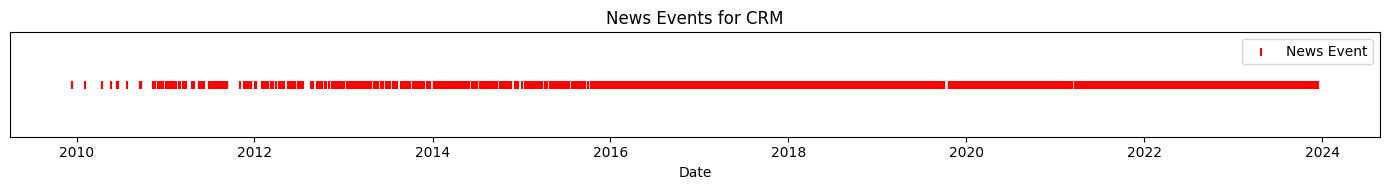

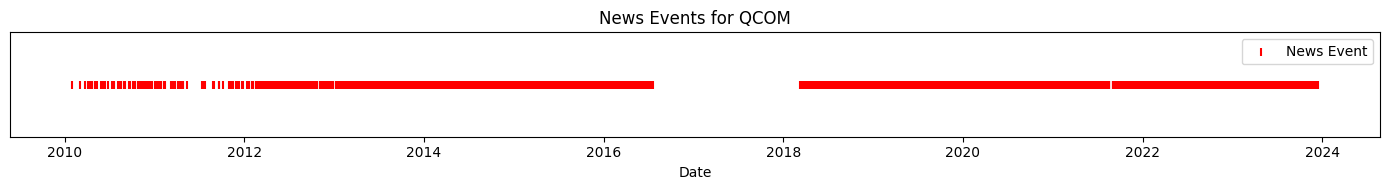

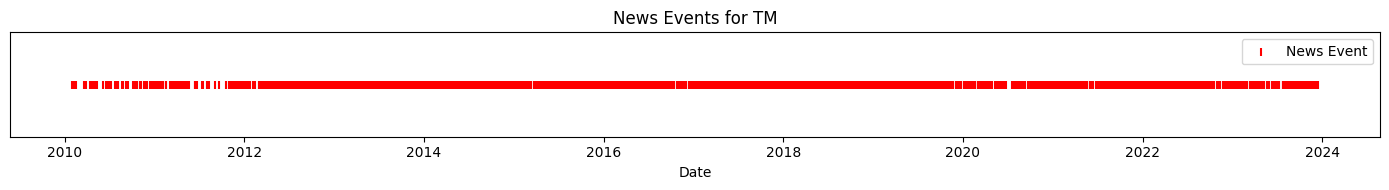

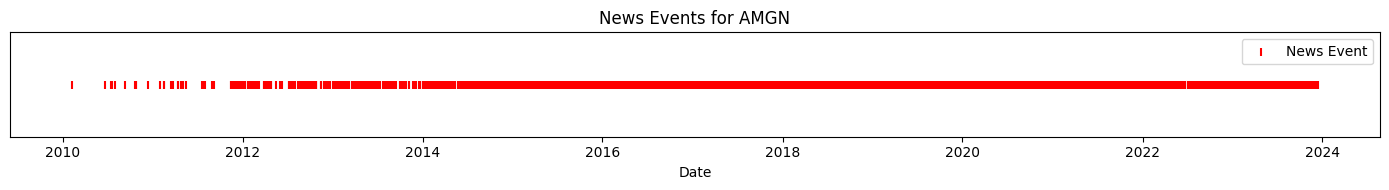

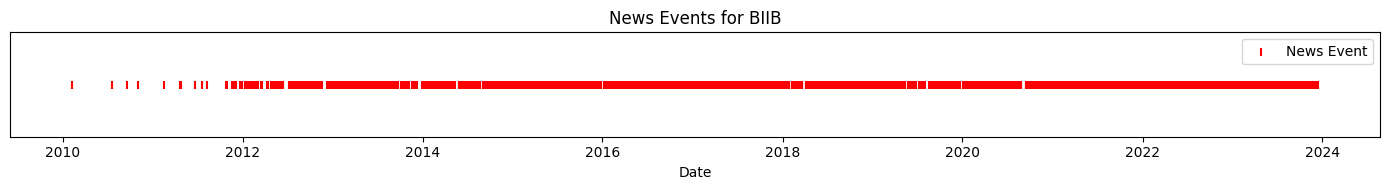

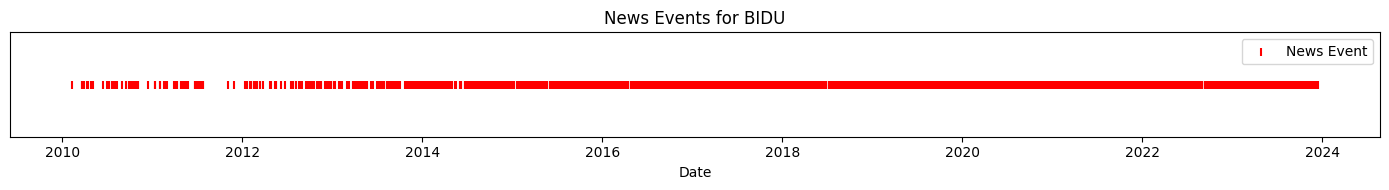

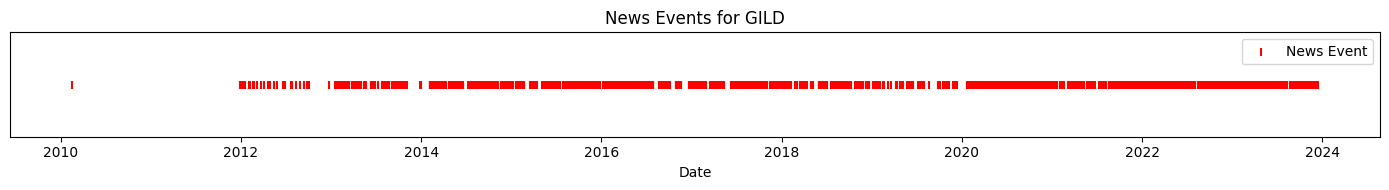

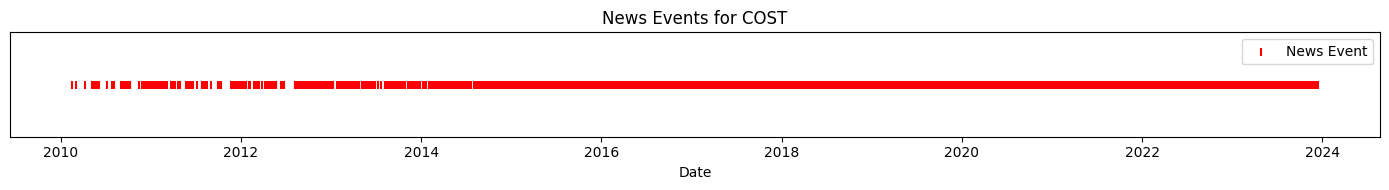

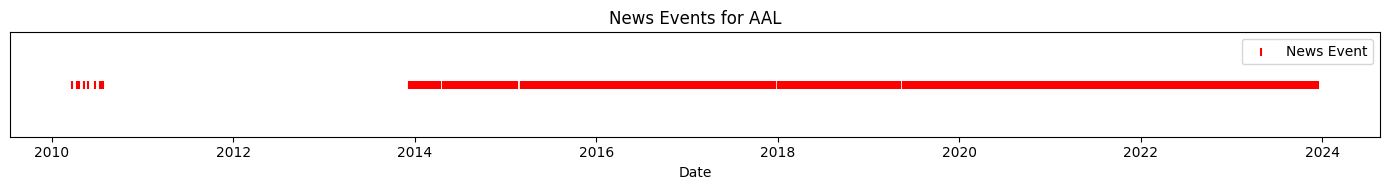

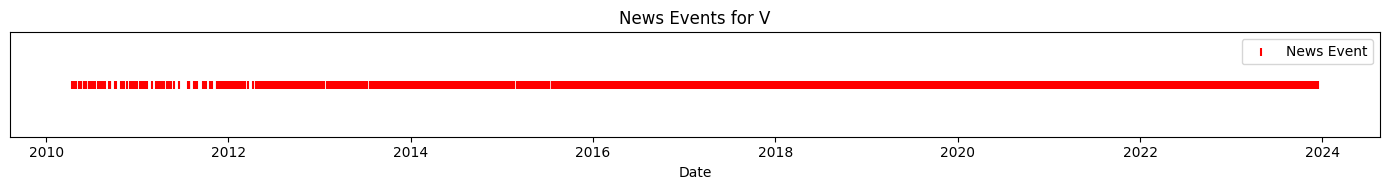

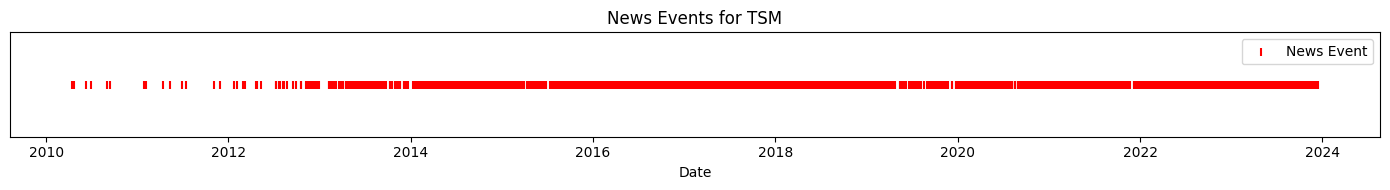

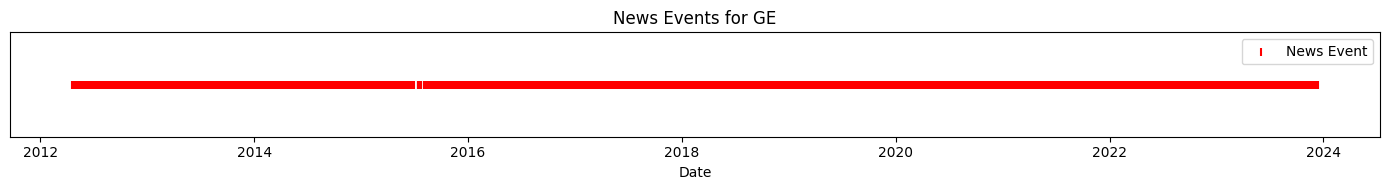

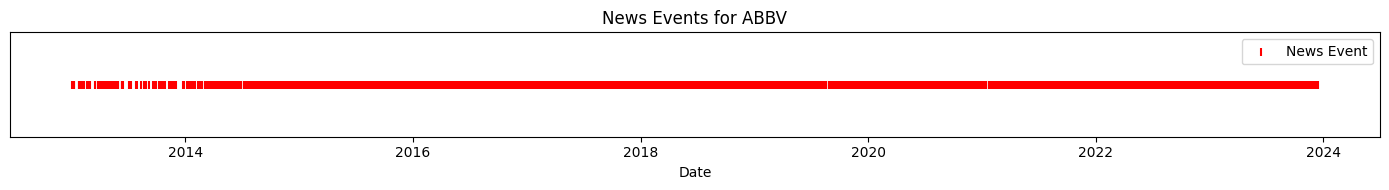

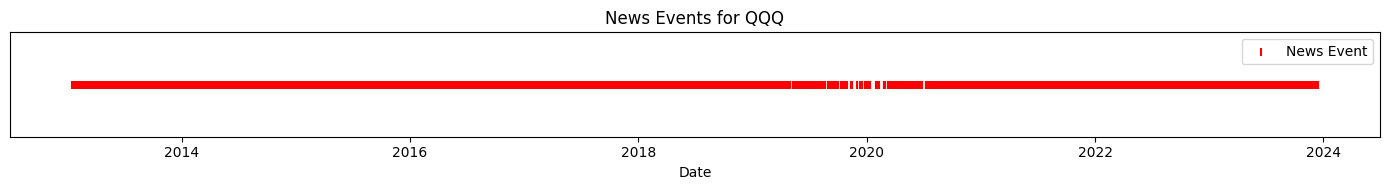

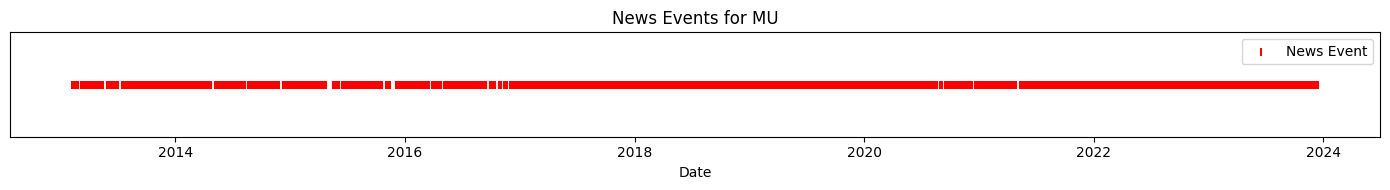

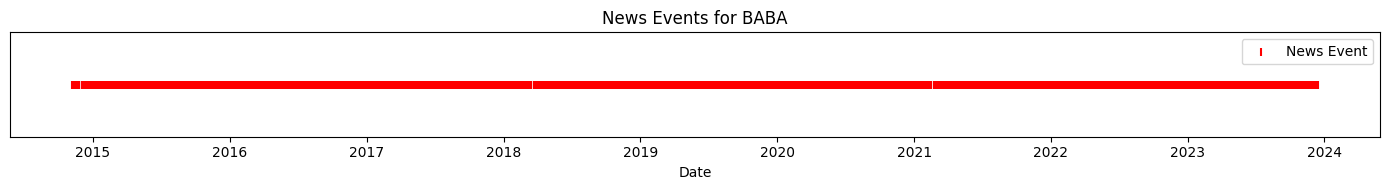

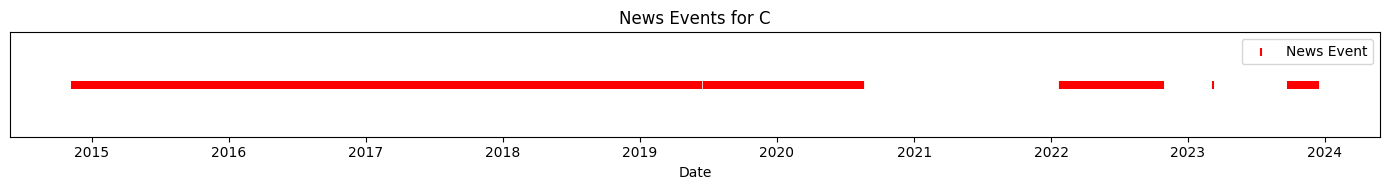

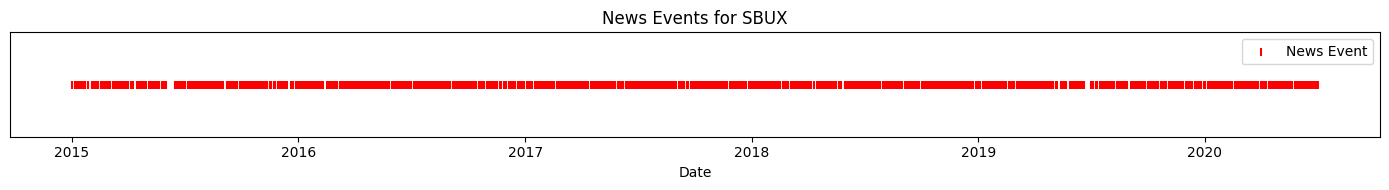

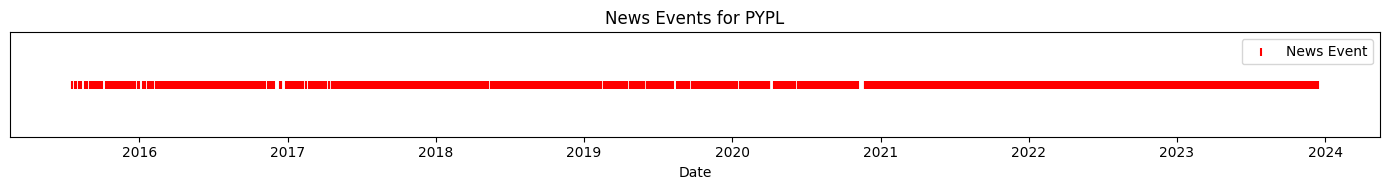

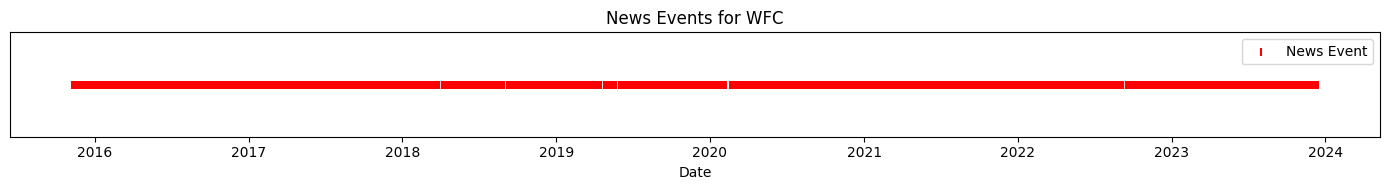

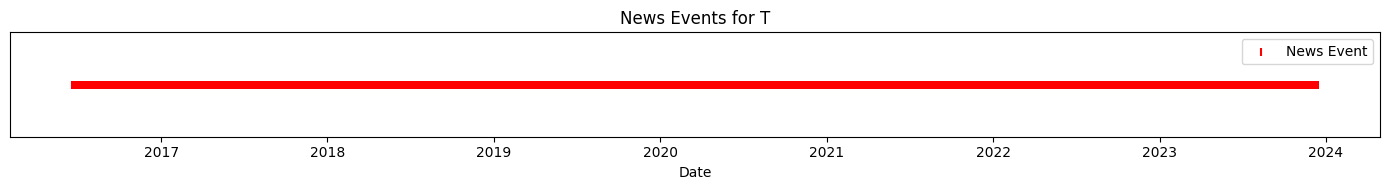

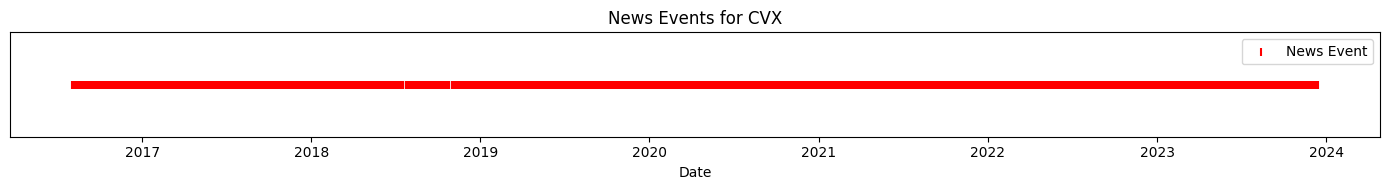

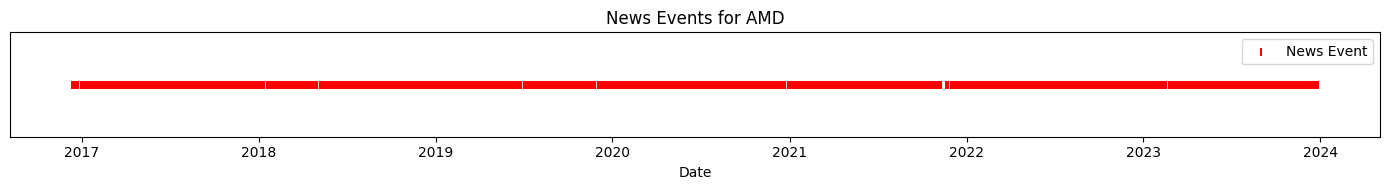

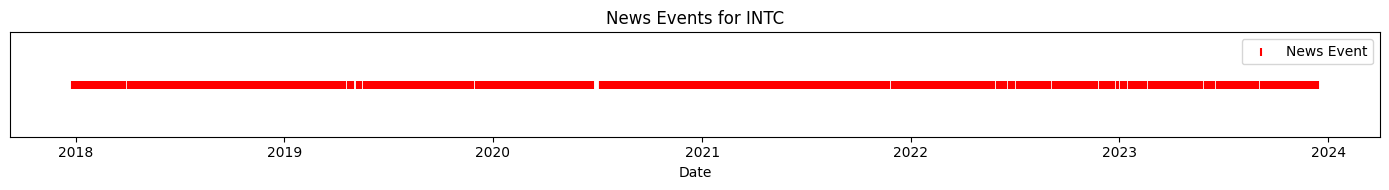

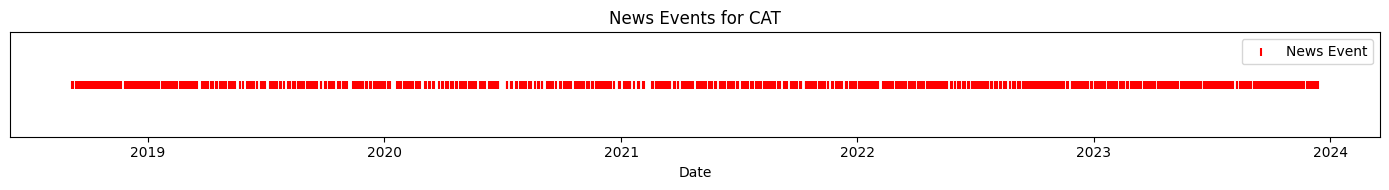

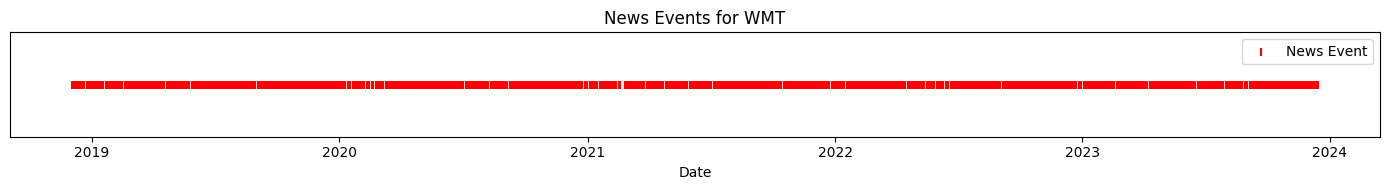

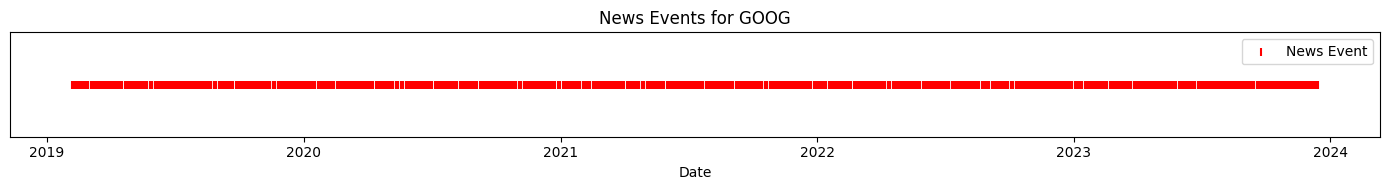

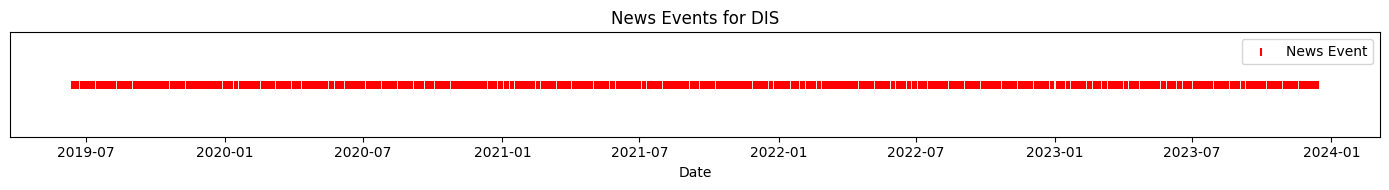

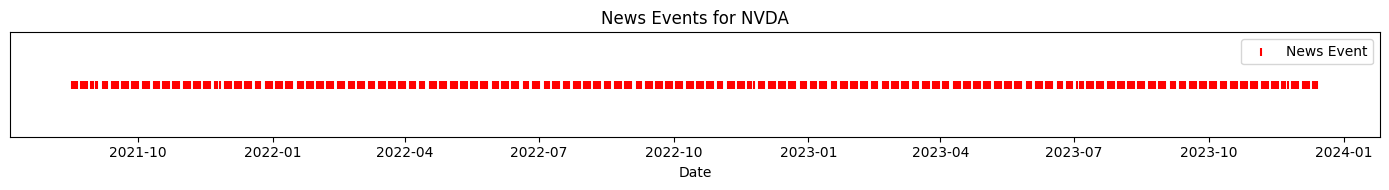

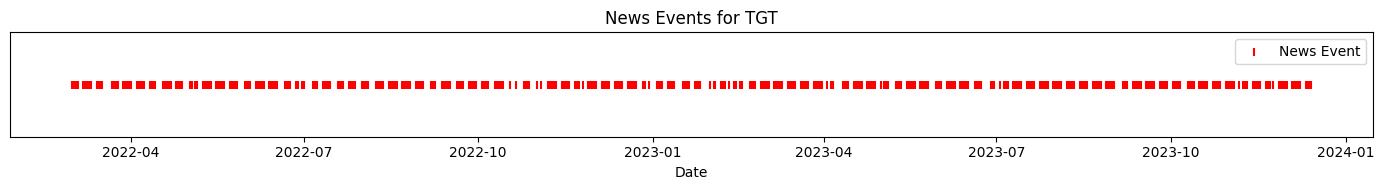

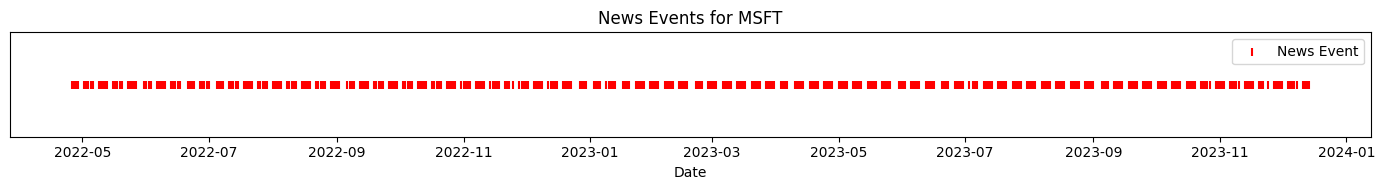

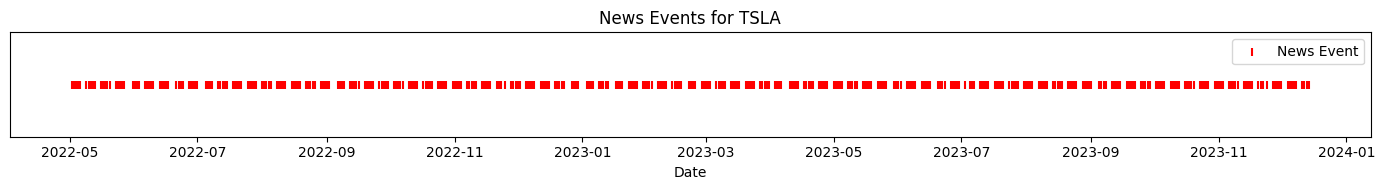

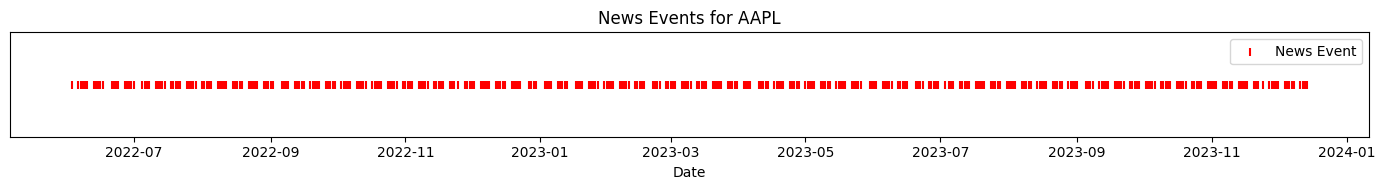

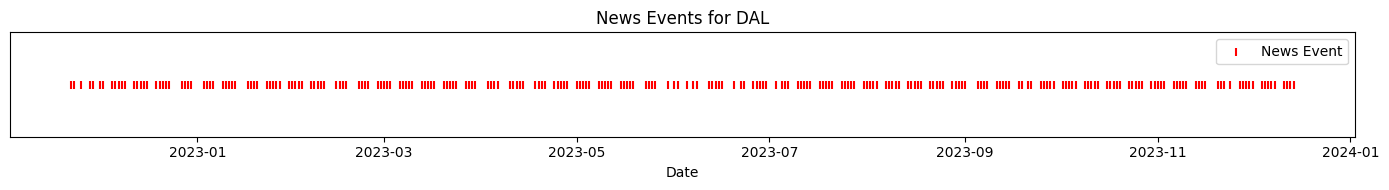

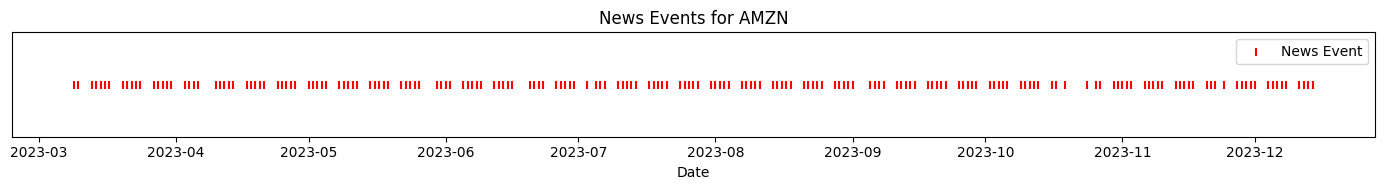

In [ ]:
for symbol in df['Symbol'].unique():
    df_symbol = df[df['Symbol'] == symbol].copy()
    df_symbol = df_symbol[df_symbol['News_flag'] == 1]  # Only keep rows where news occurred

    plt.figure(figsize=(14, 2))
    plt.scatter(df_symbol['Date'], [1] * len(df_symbol), marker='|', color='red', label='News Event')
    plt.title(f"News Events for {symbol}")
    plt.yticks([])  # Hide y-axis ticks
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
for symbol in df['Symbol'].unique():
    df_symbol = df[df['Symbol'] == symbol].copy()

    plt.figure(figsize=(14, 4))
    plt.plot(df_symbol['Date'], df_symbol['Close'], label='Close Price', alpha=0.7)

    news_dates = df_symbol[df_symbol['News_flag'] == 1]['Date']
    for date in news_dates:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.3)

    plt.title(f"Close Price with News Events for {symbol}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for symbol in df['Symbol'].unique():
    df_symbol = df[df['Symbol'] == symbol]

    # Histogram with KDE
    plt.figure(figsize=(10, 4))
    sns.histplot(df_symbol['Close'], kde=True)
    plt.title(f"{symbol} - Close Price Distribution")
    plt.xlabel("Close Price")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Boxplot
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df_symbol['Close'])
    plt.title(f"{symbol} - Close Price Boxplot")
    plt.xlabel("Close Price")
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# **Descriptive Statistics by Symbol**

In [ ]:
# Basic statistics for each symbol
desc_stats = df.groupby('Symbol')[num_cols].describe()
print(desc_stats)

<ipython-input-107-619d8a1c4c1d>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_stats = df.groupby('Symbol')[num_cols].describe()


         index                                                        \
         count      mean          std       min        25%       50%   
Symbol                                                                 
AAL     3457.0  109594.0   998.094267  107866.0  108730.00  109594.0   
AAPL     386.0   29772.5   111.572846   29580.0   29676.25   29772.5   
ABBV    2757.0   13815.0   796.021671   12437.0   13126.00   13815.0   
AMD     1772.0  101559.5   511.676656  100674.0  101116.75  101559.5   
AMGN    3487.0   20419.0  1006.754522   18676.0   19547.50   20419.0   
AMZN     195.0   83778.0    56.435804   83681.0   83729.50   83778.0   
BABA    2291.0  117588.0   661.499055  116443.0  117015.50  117588.0   
BHP     3562.0  126105.5  1028.405157  124325.0  125215.25  126105.5   
BIDU    3486.0   56681.5  1006.465846   54939.0   55810.25   56681.5   
BIIB    3487.0  113066.0  1006.754522  111323.0  112194.50  113066.0   
BRK-B   3551.0    8104.0  1025.229730    6329.0    7216.50    81

# **Boxplots Grouped by Symbol**

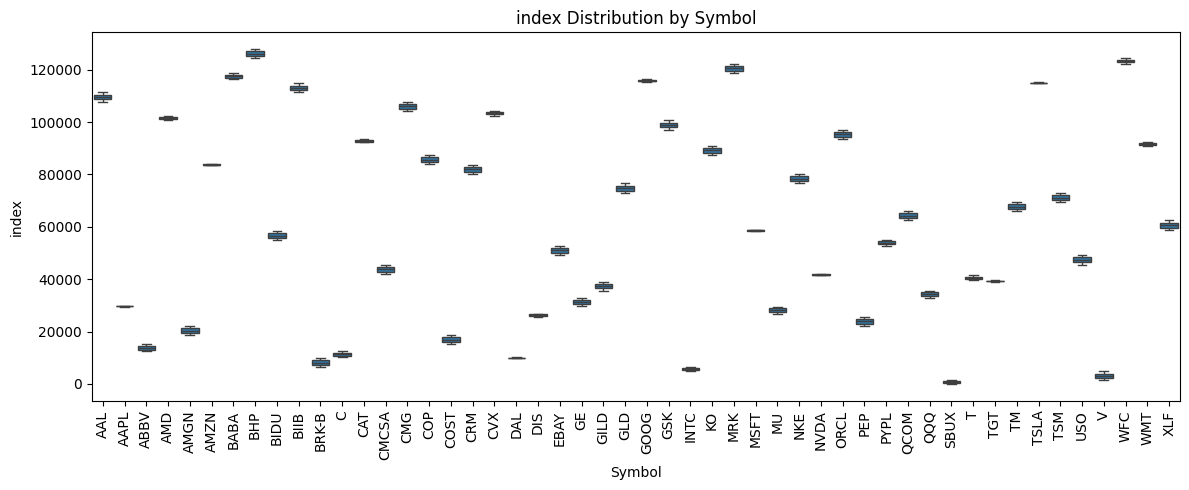

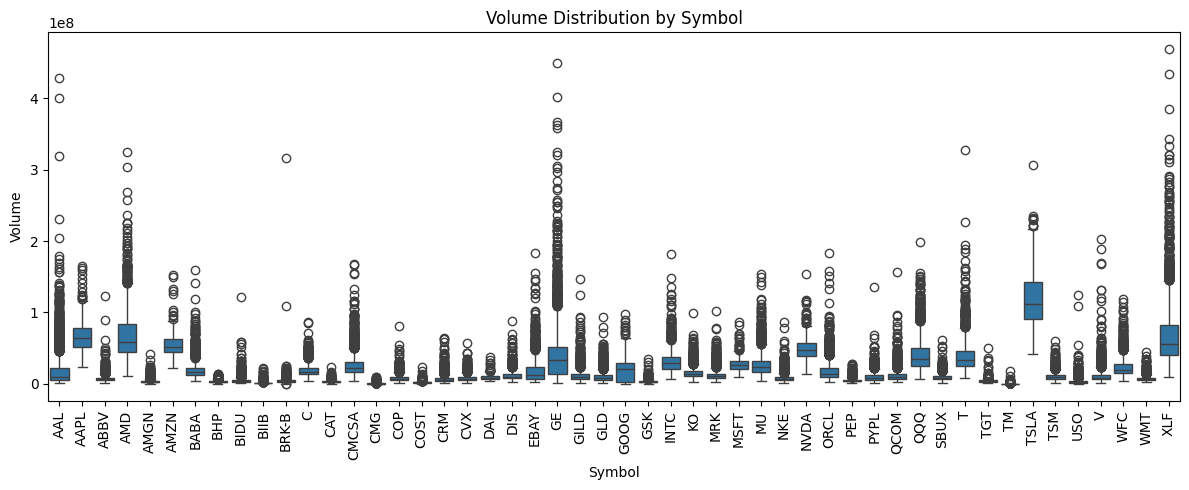

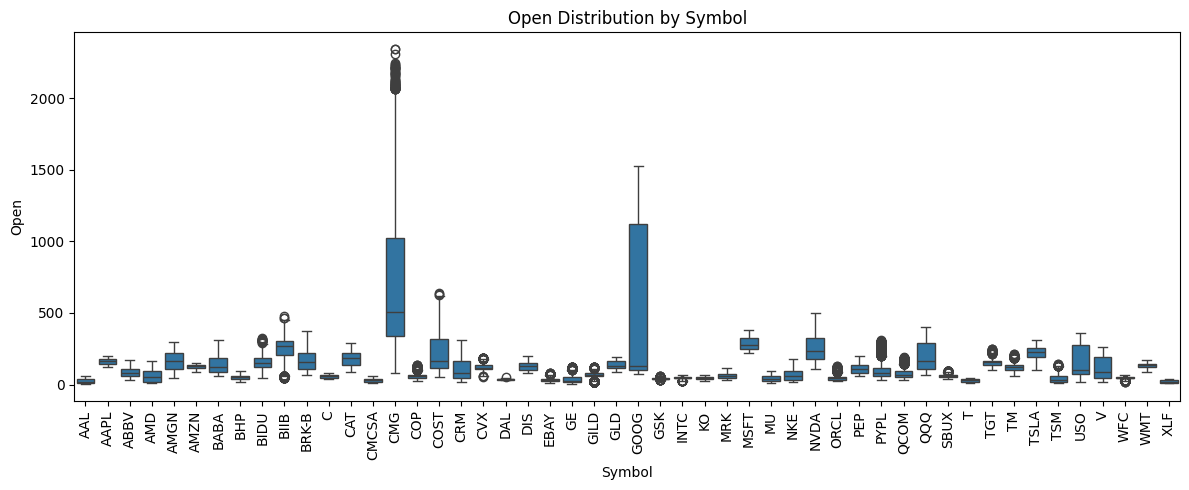

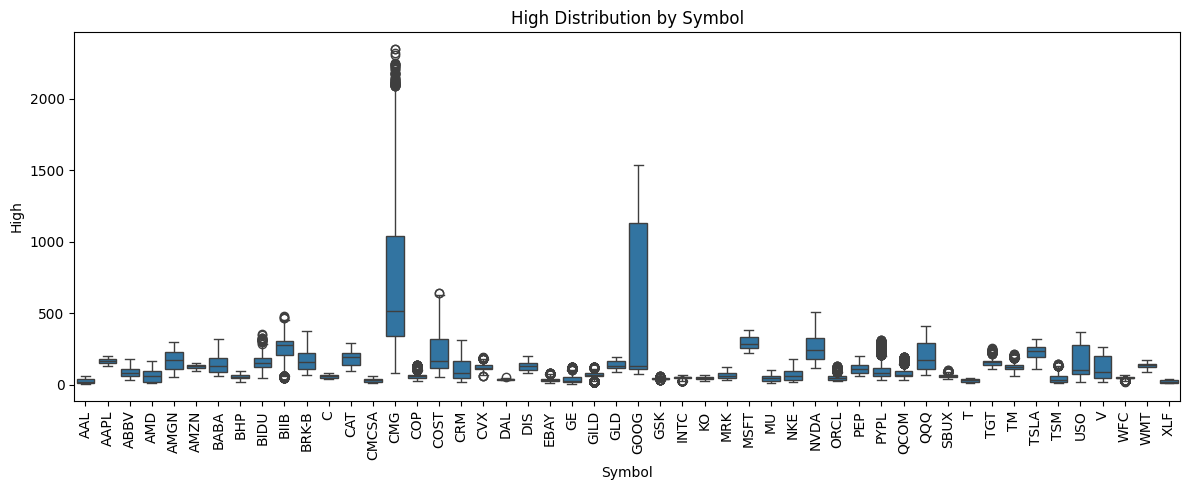

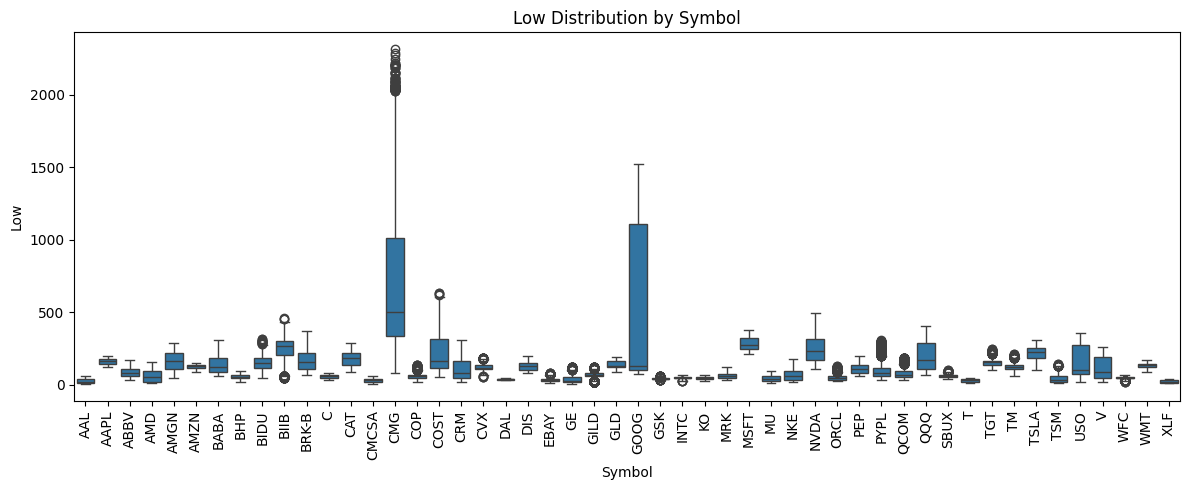

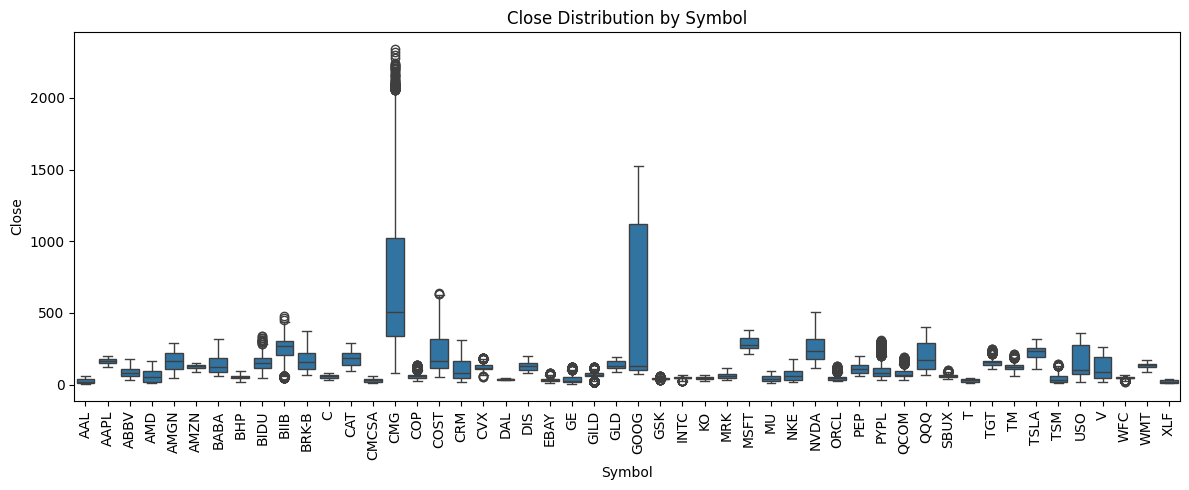

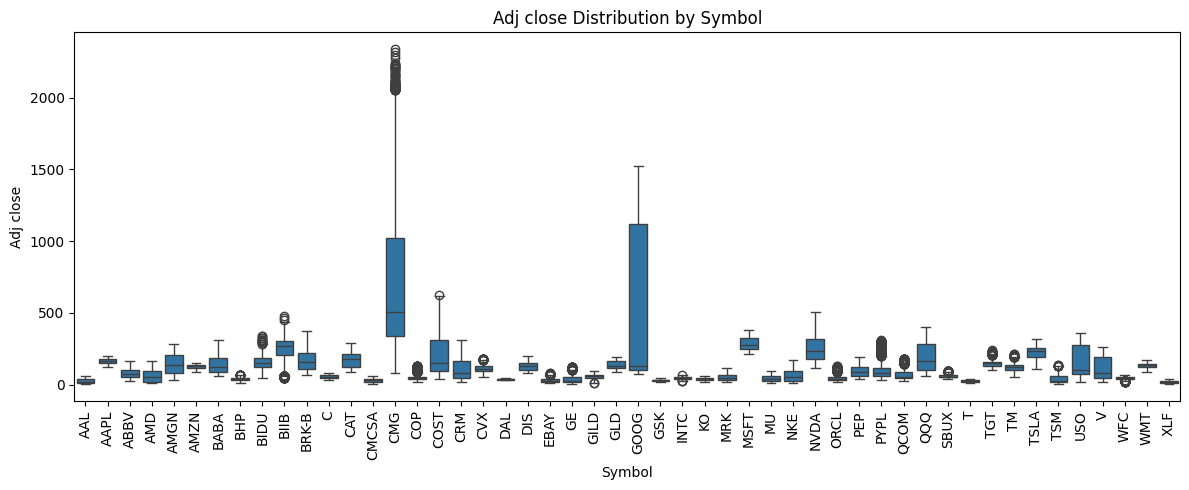

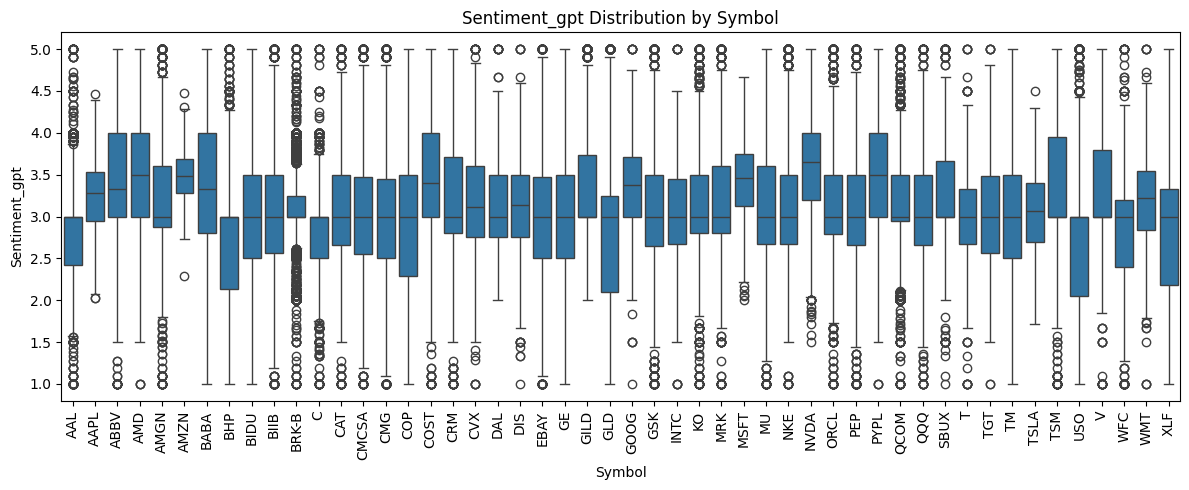

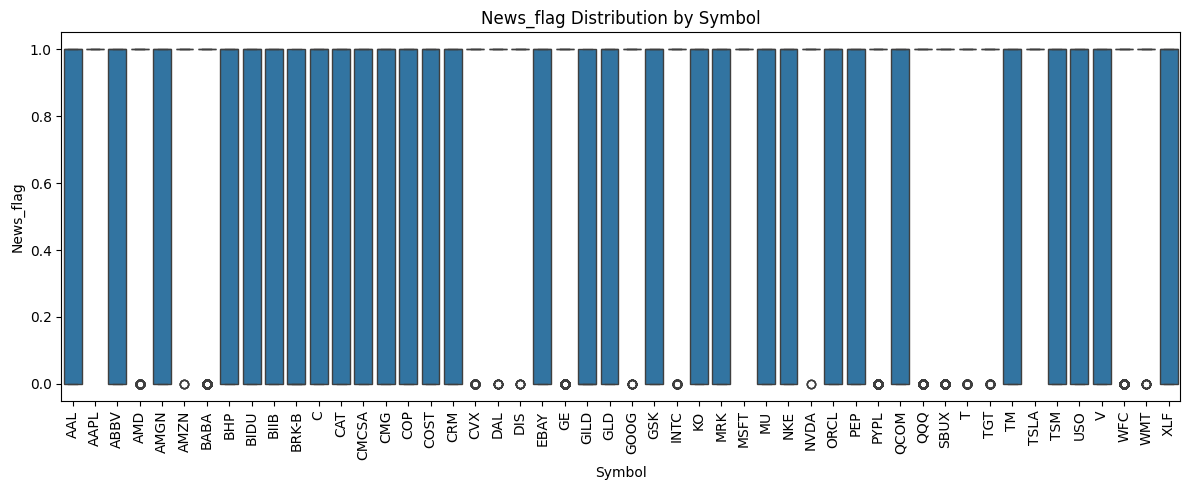

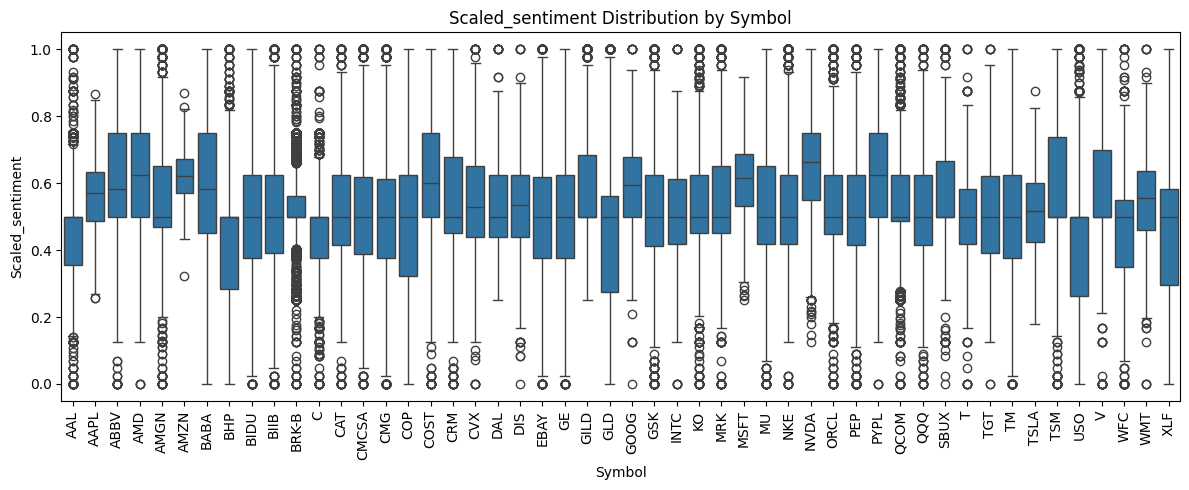

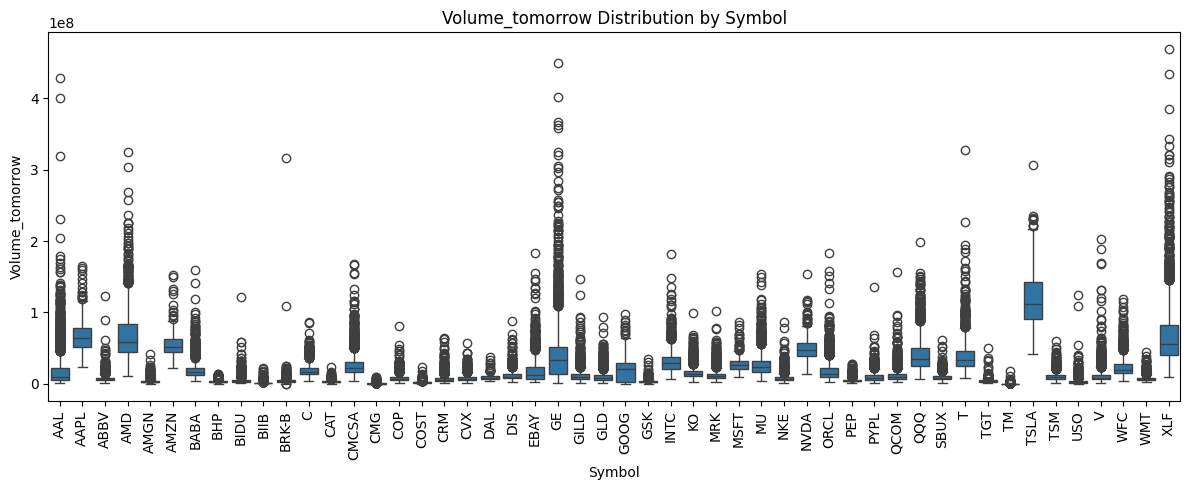

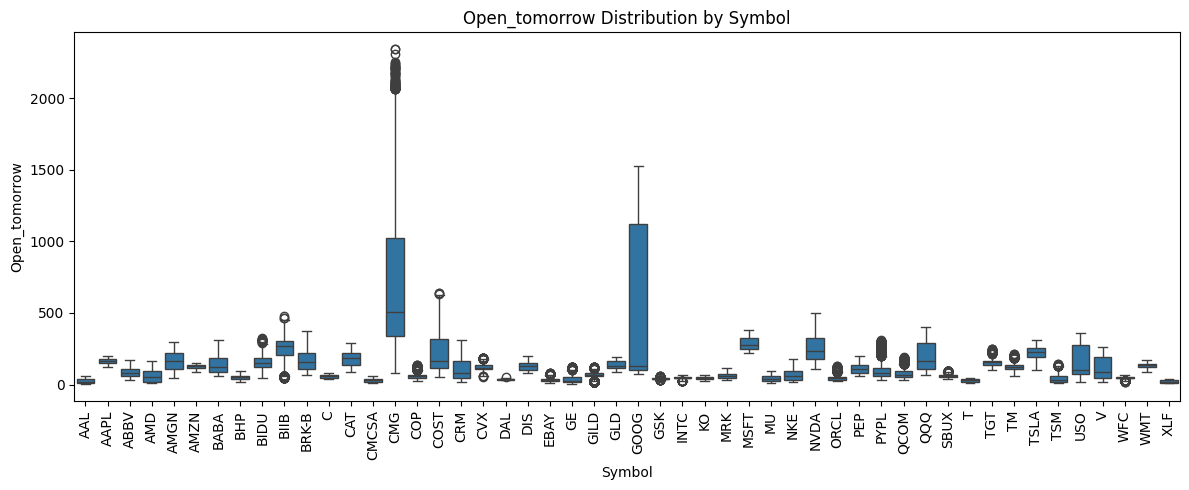

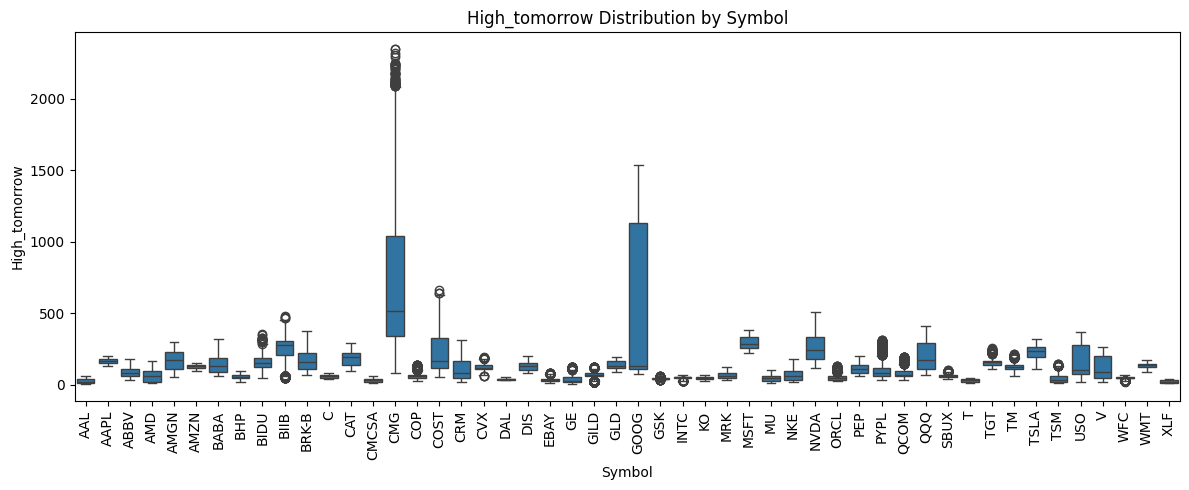

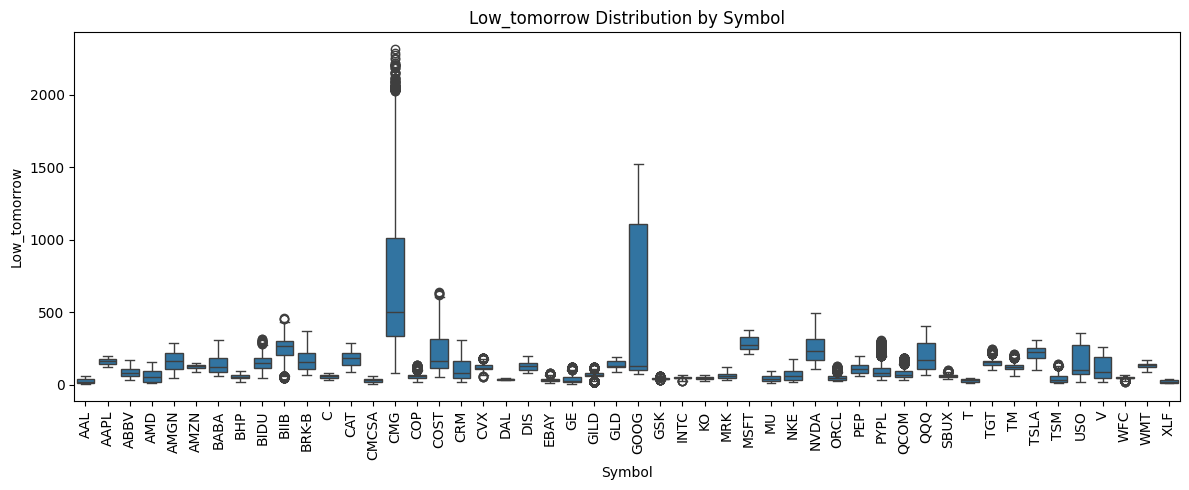

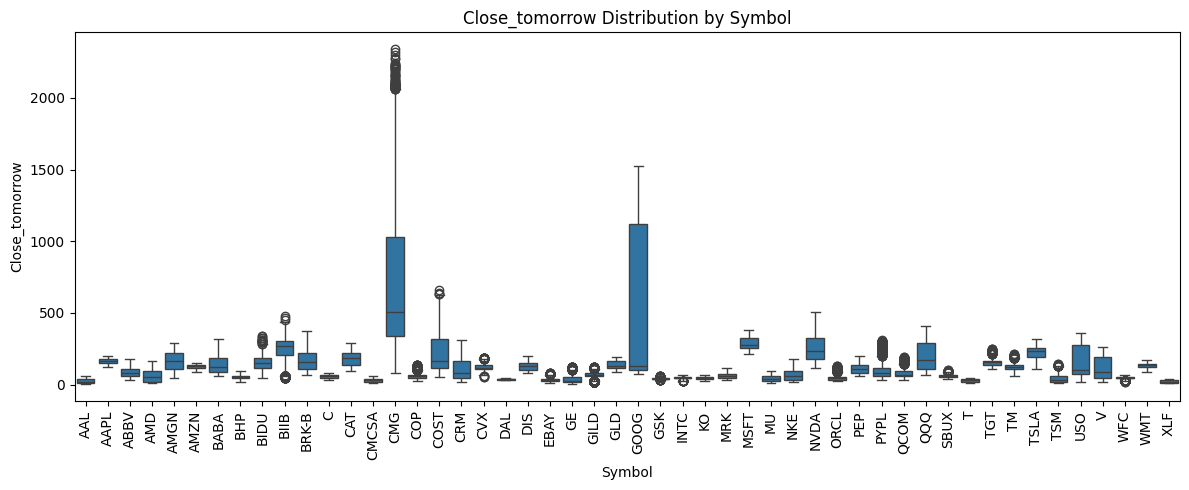

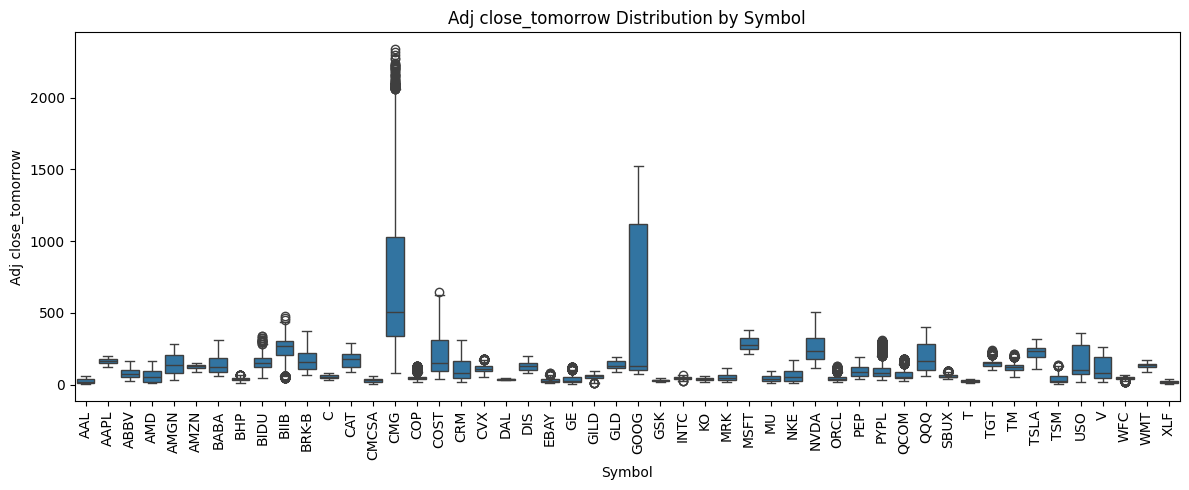

In [ ]:
for col in num_cols:
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df, x='Symbol', y=col)
    plt.title(f'{col} Distribution by Symbol')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# **Line Plots (Time-Series Trends) per Symbol**

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
symbols = df['Symbol'].unique()

for col in num_cols:
    plt.figure(figsize=(14, 6))
    for sym in symbols:
        sym_df = df[df['Symbol'] == sym]
        sns.lineplot(x='Date', y=col, data=sym_df, label=sym)
    plt.title(f'{col} Over Time by Symbol')
    plt.legend()
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **Correlation Heatmaps per Symbol**

In [ ]:
for sym in symbols:
    plt.figure(figsize=(8, 6))
    corr = df[df['Symbol'] == sym][num_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Heatmap for {sym}')
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

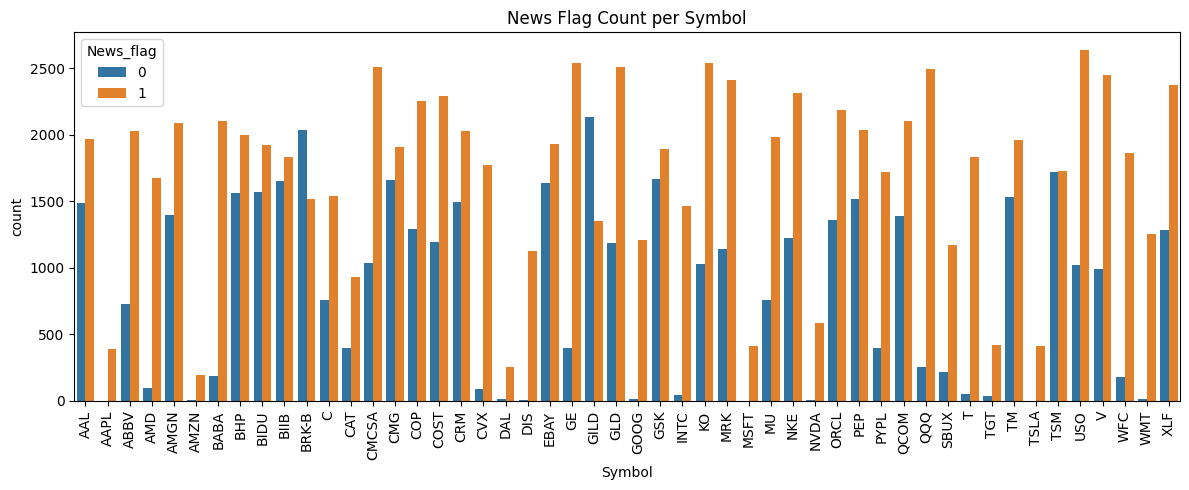

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='Symbol', hue='News_flag')
plt.title('News Flag Count per Symbol')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# **Moving Average and Rolling Volatility**

In [ ]:
for sym in df['Symbol'].unique():
    sym_df = df[df['Symbol'] == sym].sort_values('Date')
    plt.figure(figsize=(14, 6))
    plt.plot(sym_df['Date'], sym_df['Close'], label='Close')
    plt.plot(sym_df['Date'], sym_df['Close'].rolling(window=7).mean(), label='7-Day MA')
    plt.plot(sym_df['Date'], sym_df['Close'].rolling(window=7).std(), label='7-Day Volatility')
    plt.title(f'{sym} - Close Price with Moving Average & Volatility')
    plt.legend()
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **KDE (Kernel Density Estimation) per Symbol**

In [ ]:
for col in num_cols:
    plt.figure(figsize=(12, 6))
    for sym in df['Symbol'].unique():
        sns.kdeplot(df[df['Symbol'] == sym][col], label=sym, fill=True, alpha=0.2)
    plt.title(f'KDE Plot of {col} by Symbol')
    plt.legend()
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# **Outlier Detection using Z-Score**

/usr/local/lib/python3.11/dist-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


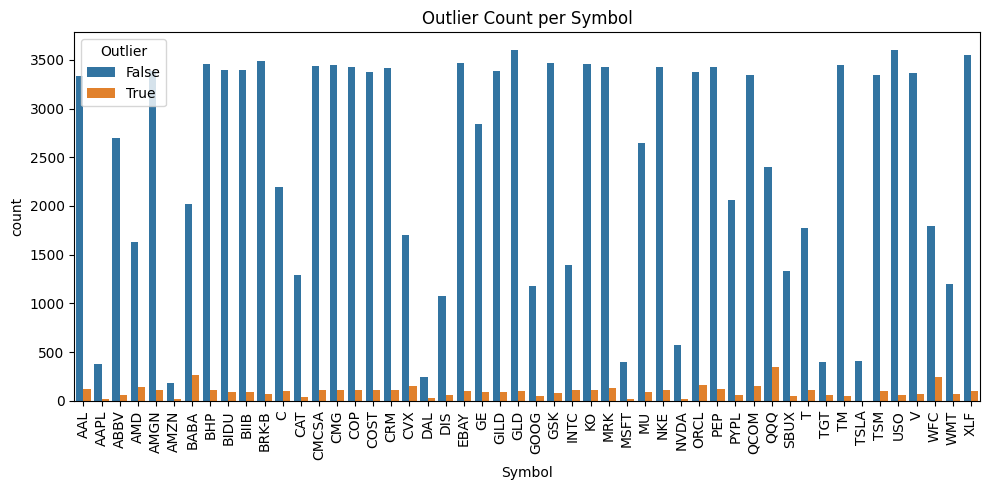

In [ ]:
from scipy.stats import zscore

# Apply z-score per symbol to avoid cross-symbol leakage
outlier_df = pd.DataFrame()
for sym in df['Symbol'].unique():
    sym_df = df[df['Symbol'] == sym].copy()
    sym_df[num_cols] = sym_df[num_cols].apply(zscore)
    sym_df['Outlier'] = sym_df[num_cols].apply(lambda row: any(abs(row) > 3), axis=1)
    outlier_df = pd.concat([outlier_df, sym_df], axis=0)

# Visualize number of outliers per symbol
plt.figure(figsize=(10, 5))
sns.countplot(data=outlier_df, x='Symbol', hue='Outlier')
plt.title('Outlier Count per Symbol')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# **Correlation Differences Between Symbols**

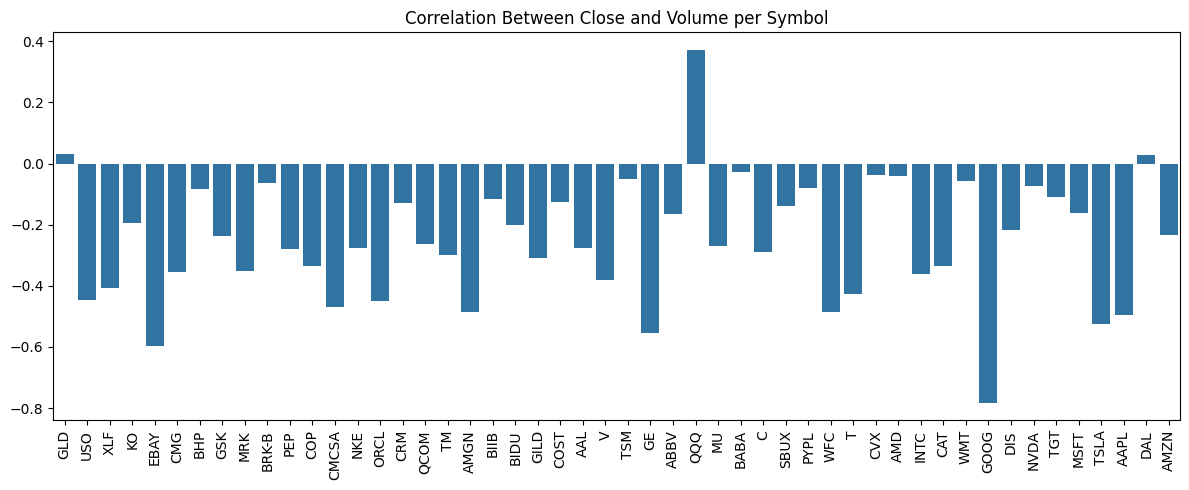

In [ ]:
import numpy as np

symbol_corrs = {}
for sym in df['Symbol'].unique():
    corr = df[df['Symbol'] == sym][num_cols].corr()
    symbol_corrs[sym] = corr

# Compare correlations (for example, Close vs Volume across symbols)
compared = {
    sym: symbol_corrs[sym].loc['Close', 'Volume']
    for sym in symbol_corrs if 'Close' in symbol_corrs[sym] and 'Volume' in symbol_corrs[sym]
}

plt.figure(figsize=(12, 5))
sns.barplot(x=list(compared.keys()), y=list(compared.values()))
plt.title('Correlation Between Close and Volume per Symbol')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# **PCA to Visualize Stock Behavior**

<ipython-input-116-1ce524cd0d03>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  symbol_avg = df.groupby('Symbol')[num_cols].mean()


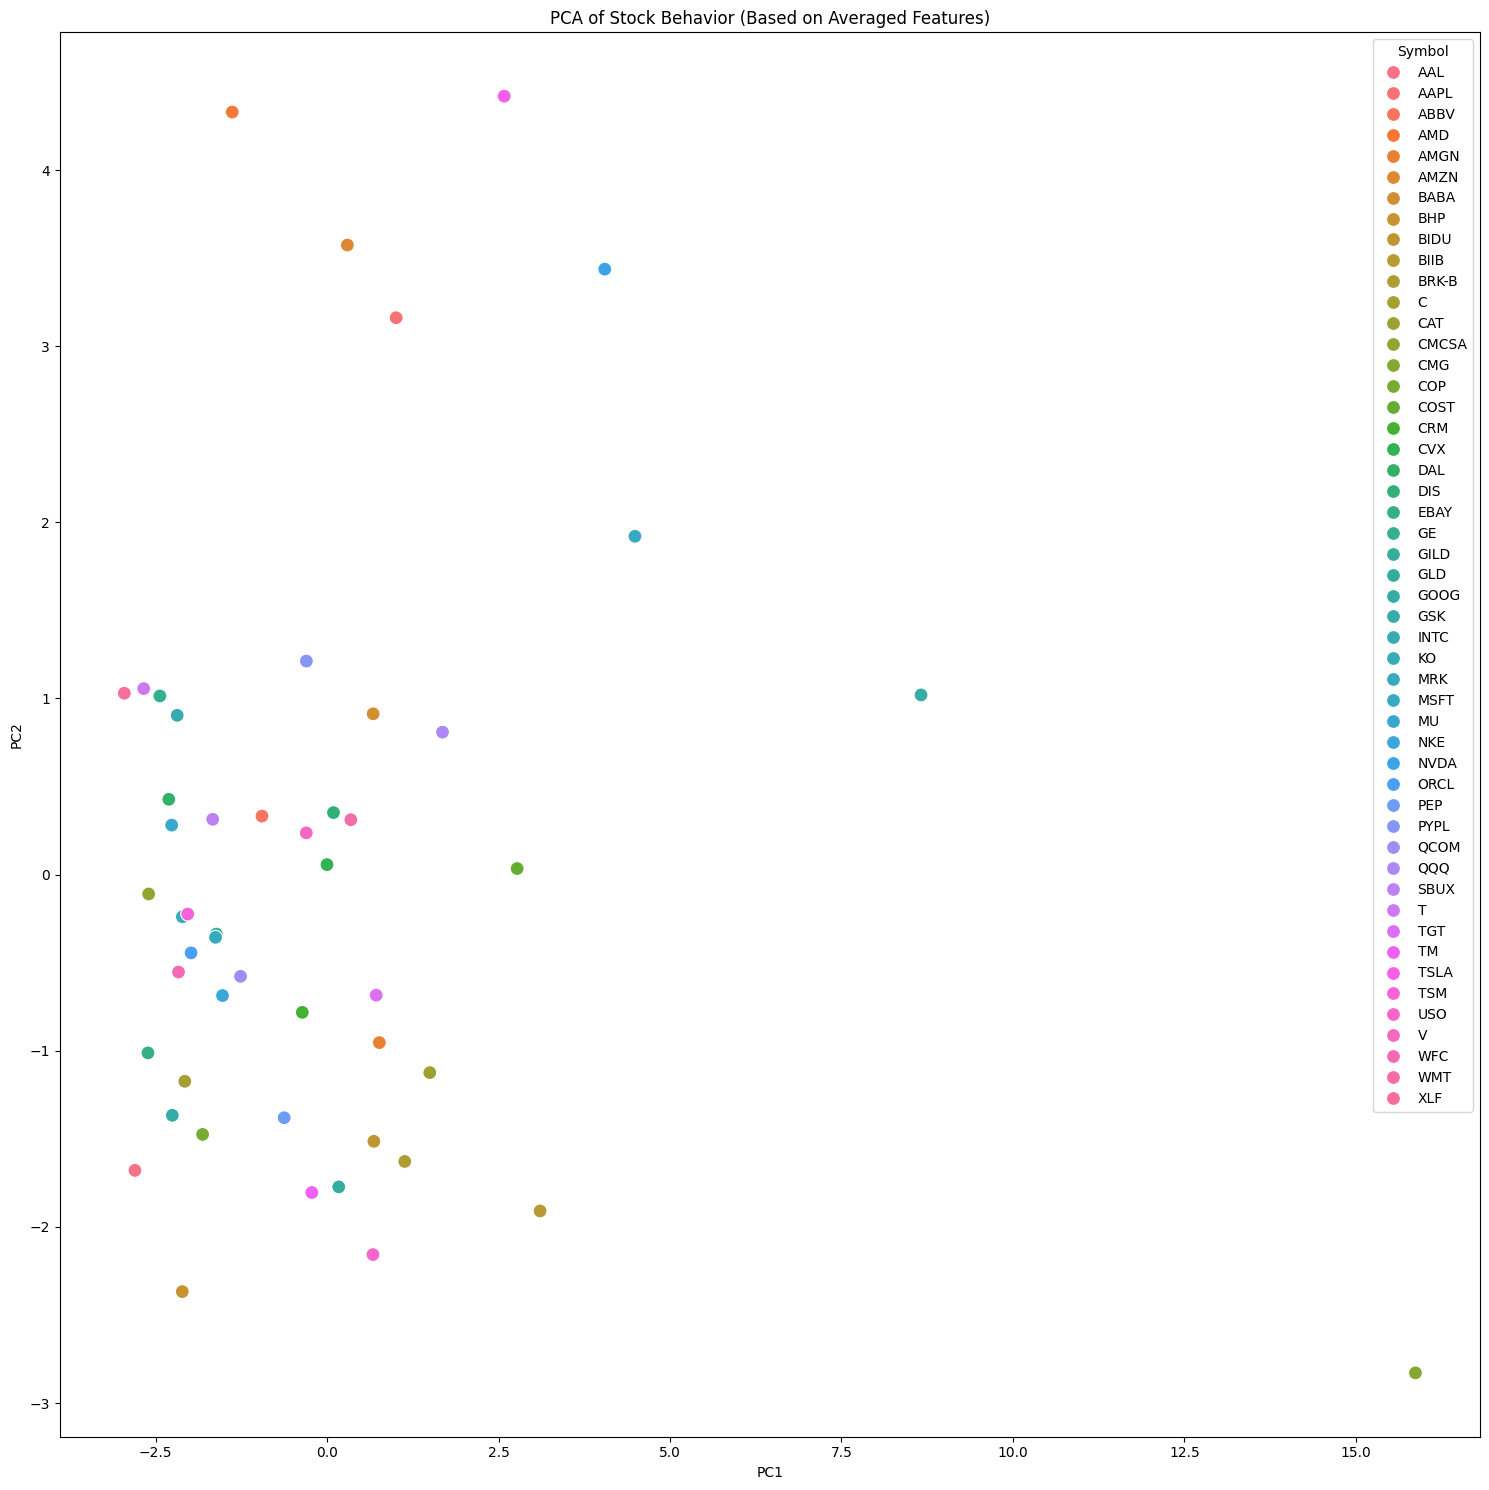

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Average numeric features per symbol
symbol_avg = df.groupby('Symbol')[num_cols].mean()

# Scale and apply PCA
scaled = StandardScaler().fit_transform(symbol_avg)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

# Plot
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Symbol'] = symbol_avg.index

plt.figure(figsize=(15, 15))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Symbol', s=100)
plt.title('PCA of Stock Behavior (Based on Averaged Features)')
plt.tight_layout()
plt.show()


# **Feature Engineering**

In [ ]:
df['high_to_low'] = df['High'] / df['Low']
df['close_to_open'] = df['Close'] / df['Open']

In [ ]:
df['daily_range_pct'] = (df['High'] - df['Low']) / df['Open']

In [ ]:
df['volume_per_price'] = df['Volume'] / df['Close']

Candle Shape Features

In [ ]:
df['body_size'] = abs(df['Close'] - df['Open'])
df['upper_shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
df['lower_shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']

In [ ]:
df.drop(columns=['high_to_low', 'close_to_open', 'daily_range_pct', 'volume_per_price', 'body_size', 'upper_shadow', 'lower_shadow'], inplace= True)

# Final Data

In [ ]:
# Final prepared data
final_data = df.copy()
final_data.to_csv("final_prepared_data.csv", index=False)
final_data.head()


,level_0,index,Date,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,...,Open_tomorrow,High_tomorrow,Low_tomorrow,Close_tomorrow,Adj close_tomorrow,Symbol,high_to_low,close_to_open,daily_range_pct,volume_per_price
0,72922,72922,2009-04-14 00:00:00+00:00,7167400.0,87.779999,87.809998,87.040001,87.370003,87.370003,3.0,...,87.419998,87.940002,87.230003,87.500000,87.500000,GLD,1.008846,0.995329,0.008772,82035.020885
1,72923,72923,2009-04-15 00:00:00+00:00,6857000.0,87.419998,87.940002,87.230003,87.500000,87.500000,3.0,...,87.379997,87.449997,85.680000,85.809998,85.809998,GLD,1.008139,1.000915,0.008122,78365.714286
2,72924,72924,2009-04-16 00:00:00+00:00,21033600.0,87.379997,87.449997,85.680000,85.809998,85.809998,3.0,...,85.750000,86.370003,84.919998,85.220001,85.220001,GLD,1.020658,0.982033,0.020256,245118.291556
3,72925,72925,2009-04-17 00:00:00+00:00,22332700.0,85.750000,86.370003,84.919998,85.220001,85.220001,3.0,...,86.029999,87.339996,86.000000,86.949997,86.949997,GLD,1.017075,0.993819,0.016910,262059.371980
4,72926,72926,2009-04-20 00:00:00+00:00,12674400.0,86.029999,87.339996,86.000000,86.949997,86.949997,3.0,...,87.849998,87.879997,86.330002,86.889999,86.889999,GLD,1.015581,1.010694,0.015576,145766.537606


In [ ]:
final_data

,level_0,index,Date,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,...,Open_tomorrow,High_tomorrow,Low_tomorrow,Close_tomorrow,Adj close_tomorrow,Symbol,high_to_low,close_to_open,daily_range_pct,volume_per_price
0,72922,72922,2009-04-14 00:00:00+00:00,7167400.0,87.779999,87.809998,87.040001,87.370003,87.370003,3.00,...,87.419998,87.940002,87.230003,87.500000,87.500000,GLD,1.008846,0.995329,0.008772,82035.020885
1,72923,72923,2009-04-15 00:00:00+00:00,6857000.0,87.419998,87.940002,87.230003,87.500000,87.500000,3.00,...,87.379997,87.449997,85.680000,85.809998,85.809998,GLD,1.008139,1.000915,0.008122,78365.714286
2,72924,72924,2009-04-16 00:00:00+00:00,21033600.0,87.379997,87.449997,85.680000,85.809998,85.809998,3.00,...,85.750000,86.370003,84.919998,85.220001,85.220001,GLD,1.020658,0.982033,0.020256,245118.291556
3,72925,72925,2009-04-17 00:00:00+00:00,22332700.0,85.750000,86.370003,84.919998,85.220001,85.220001,3.00,...,86.029999,87.339996,86.000000,86.949997,86.949997,GLD,1.017075,0.993819,0.016910,262059.371980
4,72926,72926,2009-04-20 00:00:00+00:00,12674400.0,86.029999,87.339996,86.000000,86.949997,86.949997,3.00,...,87.849998,87.879997,86.330002,86.889999,86.889999,GLD,1.015581,1.010694,0.015576,145766.537606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127882,102441,102441,2023-12-20 00:00:00+00:00,54671700.0,139.000000,139.580002,135.369995,135.470001,135.470001,4.40,...,138.139999,139.979996,137.380005,139.910004,139.910004,AMD,1.031100,0.974604,0.030288,403570.528585
127883,102442,102442,2023-12-21 00:00:00+00:00,47179400.0,138.139999,139.979996,137.380005,139.910004,139.910004,4.00,...,140.479996,140.699997,138.309998,139.600006,139.600006,AMD,1.018926,1.012813,0.018821,337212.484920
127884,102443,102443,2023-12-22 00:00:00+00:00,35370400.0,140.479996,140.699997,138.309998,139.600006,139.600006,4.00,...,140.070007,143.850006,139.919998,143.410004,143.410004,AMD,1.017280,0.993736,0.017013,253369.616429
127885,102444,102444,2023-12-26 00:00:00+00:00,47157400.0,140.070007,143.850006,139.919998,143.410004,143.410004,3.75,...,144.720001,146.250000,143.179993,146.070007,146.070007,AMD,1.028088,1.023845,0.028057,328829.222480
